Implementação final

Tese de Doutorado

Carlos Eduardo Beluzo

Jan 2024

----


# Imporatção de Libs e Preparação de Dados

In [2]:
!pip install imblearn xgboost yellowbrick shap

#### imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import numpy as np
import pickle

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import ADASYN

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDOneClassSVM
from sklearn.naive_bayes import ComplementNB, CategoricalNB, MultinomialNB
import xgboost as xgb
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import shap
from sklearn.inspection import permutation_importance
from yellowbrick.classifier import PrecisionRecallCurve

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingClassifier

scaler = MinMaxScaler()
folder = '/content/drive/MyDrive/datasets/Link_DataPop_Coorte_2014/'
folder = 'data/'

final_report = pd.DataFrame()

models = []

pd.set_option('display.max_columns', None)


#### def run_experiment

In [4]:
# X, y: Treino
# X_, y_: Teste
# X__, y__: Validação Final

def run_experiment(titulo, clf, X, y, X_, y_, X__, y__, final_report):
  # Treino/Teste
  clf.fit(X, y)
  y_pred = clf.predict(X_)
    
  if type(clf).__name__ in ['IsolationForest','SGDOneClassSVM', 'OneClassSVM']:
    y_pred = [1 if i==-1 else 0 for i in y_pred]

  classification_rep = imprime_metricas(X, X_, y_, y_pred, clf=clf,
                                        graficos=True, titulo=titulo)

  final_report = pd.concat([final_report, classification_rep], ignore_index=True)

  # Validação
  y_pred_val = clf.predict(X__)
    
  if type(clf).__name__ in ['IsolationForest','SGDOneClassSVM', 'OneClassSVM']:
    y_pred_val = [1 if i==-1 else 0 for i in y_pred_val]

  classification_rep = imprime_metricas(X, X__, y__, y_pred_val, clf=clf,
                                        graficos=False, titulo=titulo[:4] + 'V: Validação')
  
  final_report = pd.concat([final_report, classification_rep], ignore_index=True)

  return final_report, clf

#### imprime_metricas

In [5]:
def imprime_metricas(X_train, X_test, y_test, y_pred, clf=None, graficos=False, titulo='Gráfico'):
  print('-------------------------------------------------------------')
  print(titulo + ' - ' + type(clf).__name__ )
  print('-------------------------------------------------------------')
  
  # Avalie o desempenho do modelo
  conf_matrix = confusion_matrix(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)
  classification_rep = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

  classification_rep = pd.DataFrame(classification_rep).transpose().round(2)
  classification_rep.reset_index(inplace=True)
  experiment_number = [titulo[:5]] * 5

  # Adding new column at the first index
  classification_rep.insert(0, '#', experiment_number)
  classification_rep['support'] = classification_rep['support'].astype(int)
  classification_rep['Descrição'] = titulo

  # Imprima as métricas de avaliação
  print("Relatório de Classificação:")
  print(classification_rep[['index','precision','recall','f1-score','support']])
  print('-------------------------------------------------------------')

  if graficos:
    # Matrix Confusão ---------------------------------------------------------
    plt.figure(figsize=(2, 2))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 10})
    plt.title("Matrix de Confusão", fontsize=11)
    plt.xlabel('Valores Preditos', fontsize=10)
    plt.ylabel('Valores Reais', fontsize=10)
    plt.show()

    print('')
    # Curva ROC ----------------------------------------------------------------
    
    if type(clf).__name__ in ['OneClassSVM','IsolationForest', 'SGDOneClassSVM']:
        anomaly_scores = clf.decision_function(X_test)
        predicted_probabilities = -anomaly_scores
    else:
        predicted_probabilities = clf.predict_proba(X_test)[:, 1]  # Probability of positive class
      
      
    fpr, tpr, _ = roc_curve(y_test, predicted_probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos',fontsize=11)
    plt.ylabel('Taxa de Verdadeiros Positivos',fontsize=11)
    plt.title('Curva ROC',fontsize=12)
    plt.legend(loc="lower right")
    plt.show()
    print('')

    # Feature Importance - Top 10 ----------------------------------------------

    if type(clf).__name__ in ['OneClassSVM']:
      return classification_rep

    if type(clf).__name__ in ['LogisticRegression', 'LogisticRegressionCV']:
      coefficients = clf.coef_[0]

    if type(clf).__name__ in ['SGDOneClassSVM']:
      coefficients = np.abs(clf.coef_)

    elif type(clf).__name__ == 'XGBClassifier':
      coefficients = clf.feature_importances_

    elif type(clf).__name__ == 'IsolationForest':
      coefficients = np.mean([tree.tree_.compute_feature_importances(normalize=False) for tree in clf.estimators_], axis=0)
    
    elif type(clf).__name__ in ['ComplementNB','MultinomialNB']:
      coefficients = np.exp(clf.feature_log_prob_)[1]  # Assuming importances for the positive class

    # Plot
    coefficients = np.abs(coefficients)
    top_indices = np.argsort(coefficients)[::-1][:10]
    top_coefficients = coefficients[top_indices]
    sorted_indices = np.argsort(top_coefficients)[::-1][:10]

    #  Get the top 10 feature names and coefficients, sorted in descending order
    top_feature_names = [feature_names[i] for i in top_indices]

    top_features = np.array(top_feature_names)[sorted_indices]
    top_importances = np.array(top_coefficients)[sorted_indices]

    plt.figure(figsize=(8, 4))
    plt.barh(top_features[::-1], top_importances[::-1], color='skyblue')
    plt.xlabel('Magnitude do Coeficiente',fontsize=11)
    plt.ylabel('Variáveis (Features)',fontsize=11)
    plt.title('Importância de Variáveis (Feature Importance) - Top 10',fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.yticks(fontsize=9)  # Adjust the font size (12 is just an example)

    plt.show()
    print(top_features)
    print('')

    # SHAP --------------------------------------------------------------------
    if type(clf).__name__ in ['LogisticRegression','XGBClassifier', 'LogisticRegressionCV']:
      explainer = shap.Explainer(clf, X_train)
      shap_values = explainer(X_test)
      shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="violin", max_display=10, show=False)
      plt.title('Explicação de influência de variáveis por SHAP', fontsize=12)
      plt.xlabel('Magnitude de influência', fontsize=11)
      plt.ylabel('Variáveis (Features)', fontsize=11)
      plt.yticks(fontsize=9)  # Adjust the font size (12 is just an example)

      plt.gcf().set_size_inches(10, 4)
      plt.show()
        
  else:
      initial_evaluation(clf, X_test, y_test, y_pred)
  
  return classification_rep


#### def pizza

In [6]:
def pizza(df, titulo=''):
  plt.figure(figsize=(5, 3))
  sns.set(style="whitegrid")

  # Crie um gráfico de donuts com Seaborn
  data = df['OBITO_NEONATAL'].value_counts()
  ax = plt.pie(data, labels=['Sobreviventes', 'Óbitos'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'],
              wedgeprops={'edgecolor': 'gray'}, startangle=90, pctdistance=0.5)
  plt.title('Distribuição entre classes ' + titulo)

  # Adicione valores absolutos como legendas
  total_count = len(df)
  abs_values = [f'{count}' for count in data]
  plt.legend(abs_values, title='Totais', loc='center left', bbox_to_anchor=(0.6, 0.25))

  plt.show()


#### def initial_evaluation

In [7]:
def initial_evaluation(clf, X_test, y_test, y_pred = None):
    if y_pred is None:
        y_pred = clf.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    
    # Compute ROC curve
    # Assuming y_val contains binary labels (0 and 1) and ensemble_probs contains predicted probabilities for class 1
    try:
        proba = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1]) 
        
        # Compute ROC area under the curve (AUC)
        roc_auc = roc_auc_score(y_test, proba[:, 1])
        
        # Plot ROC curve
        plt.figure(figsize=(4,4))
        plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    except:
        None

In [8]:
def peso_distro(X_, y_):
    df_aux = X_.copy()
    df_aux['OBITO_NEONATAL'] = y_.copy()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # Create subplots with 1 row and 2 columns

    # Plot for PESO distribution
    sns.kdeplot(data=df_aux[df_aux['OBITO_NEONATAL'] == 0], x='PESO', label='Sobreviventes', fill=True, ax=axes[0])
    sns.kdeplot(data=df_aux[df_aux['OBITO_NEONATAL'] == 1], x='PESO', label='Óbitos Neonatais', fill=True, ax=axes[0])
    axes[0].set_xlabel('Log(Peso recém-nascido)')
    axes[0].set_ylabel('Densidade')
    axes[0].legend()

    # Plot for IDADEMAE distribution
    sns.kdeplot(data=df_aux[df_aux['OBITO_NEONATAL'] == 0], x='IDADEMAE', label='Sobreviventes', fill=True, ax=axes[1])
    sns.kdeplot(data=df_aux[df_aux['OBITO_NEONATAL'] == 1], x='IDADEMAE', label='Óbitos Neonatais', fill=True, ax=axes[1])
    axes[1].set_xlabel('Log(Idade materna)')
    axes[1].set_ylabel('Densidade')
    axes[1].legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


## Carregando conjunto de dados

['LINKAGE_QTDFILVIVOANT', 'LINKAGE_QTDFILMORTANT', 'LINKAGE_PREMATANT', 'LINKAGE_BAIXOPESOANT', 'LINKAGE_DIAS', 'LOCNASC', 'IDADEMAE', 'ESTCIVMAE', 'CODOCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GESTACAO', 'GRAVIDEZ', 'PARTO', 'CONSULTAS', 'DT_NASC', 'SEXO', 'APGAR1', 'APGAR5', 'RACACOR', 'PESO', 'IDANOMAL', 'ESCMAE2010', 'RACACORMAE', 'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 'SEMAGESTAC', 'CONSPRENAT', 'MESPRENAT', 'TPAPRESENT', 'STTRABPART', 'STCESPARTO', 'TPNASCASSI', 'TPROBSON', 'PARIDADE', 'KOTELCHUCK', 'DT_OBITO', 'CAUSABAS', 'DIAS_DE_VIDA', 'OBITO_NEONATAL']
Dimensões (88930, 817)

Index(['LINKAGE_QTDFILVIVOANT', 'LINKAGE_QTDFILMORTANT', 'LINKAGE_PREMATANT',
       'LINKAGE_BAIXOPESOANT', 'LINKAGE_DIAS', 'LOCNASC', 'IDADEMAE',
       'ESTCIVMAE', 'QTDFILVIVO', 'QTDFILMORT',
       ...
       'SEMAGESTAC_36', 'SEMAGESTAC_37', 'SEMAGESTAC_38', 'SEMAGESTAC_39',
       'SEMAGESTAC_40', 'SEMAGESTAC_41', 'SEMAGESTAC_42', 'SEMAGESTAC_43',
       'SEMAGESTAC_44', 'SEMAGESTAC_45'],
      dt

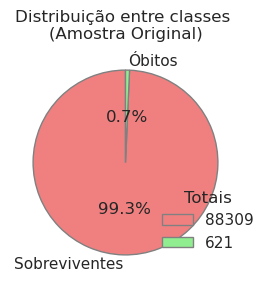

In [9]:
df = pd.read_csv(folder + 'Mortes_infantil_RJ.csv')
print(df.columns.tolist())

# Transformando dados não numéricos descritivos em categoricos
#df['CAUSABAS'] = df['CAUSABAS'].astype('category').cat.codes

df = pd.get_dummies(df, columns=['CODOCUPMAE'], prefix=['CODOCUPMAE'])
df = pd.get_dummies(df, columns=['APGAR1'], prefix=['APGAR1'])
df = pd.get_dummies(df, columns=['APGAR5'], prefix=['APGAR5'])
df = pd.get_dummies(df, columns=['CONSPRENAT'], prefix=['CONSPRENAT'])
df = pd.get_dummies(df, columns=['MESPRENAT'], prefix=['MESPRENAT'])
df = pd.get_dummies(df, columns=['SEMAGESTAC'], prefix=['SEMAGESTAC'])

df = df.drop(['DIAS_DE_VIDA', 'CAUSABAS','DT_NASC','DT_OBITO'], axis=1).copy()

print('Dimensões', df.shape)
print()
print(df.columns)
print()

pizza(df, '\n(Amostra Original)')

# 1) Divisão do conjunto de dados

## 1.1) Divisão de conjunto de dados em Validação, Treino e Teste

O conjunto de dados possui um total 88.930 registros, sendo 88.309 da classe 0 (sobreviventes) e 621 da classe 1 (óbitos neonatais), o que significa que estamos lidando com um problema que apresenta um conjunto de dados fortemente desbalanceado entre as classes.

Para divisão do conjunto de adotada a seguinte estratégia: do conjunto inicial 20% dos dados são separados para validação final; os 80% restantes, são divididos entre dados de treino e dados de teste na proporção 80% para treino e 20% para teste. As colunas 'DIAS_DE_VIDA', 'CAUSABAS', 'DT_NASC' e 'DT_OBITO' são removidas do conjunto de dados para os experimentos desta seção. A vairável 'CAUSABAS' será avaliada individualmente em experimentos posteriores, pois sua inclusão iria superajustar o modelo, uma vez que apenas os registros de mortes possuem esta informação. Com isso o conjunto de dados é particionado em três subconjuntos distintos: um conjunto de validação (X_val, y_val), um conjunto de treinamento (X_train, y_train) e um conjunto de teste (X_test, y_test). A divisão é realizada por meio da função 'train_test_split', incorporando um tamanho de teste de 20% e um estado aleatório fixo para garantir a reprodutibilidade.

Subconjunto, sobreviventes, óbitos neonatais
Validação, 17671, 115
Treino, 56508, 407
Teste, 14130, 99

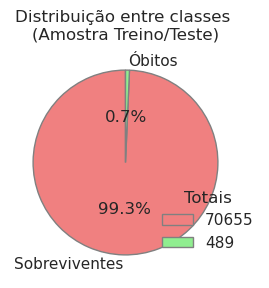

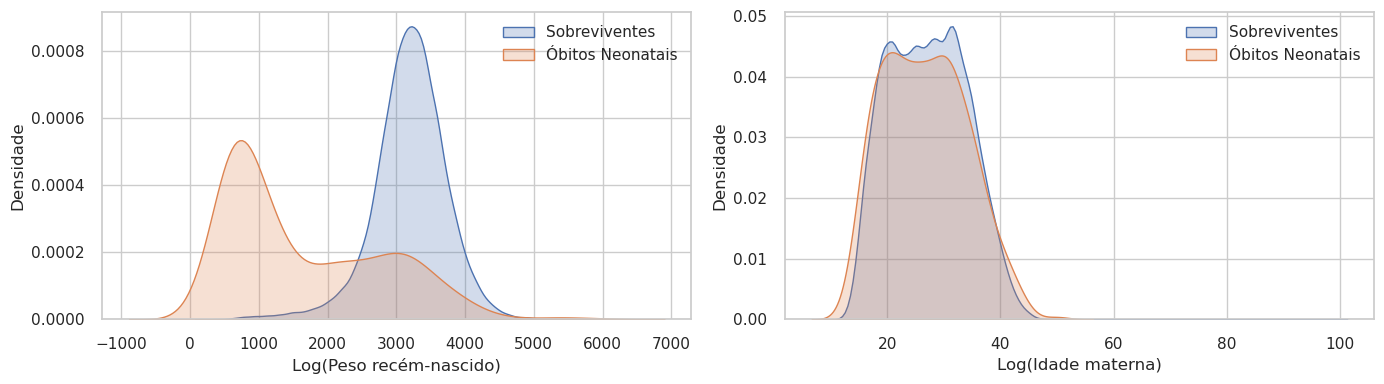

0       1      2
                  Validação  Treino  Teste
sobreviventes         17654   56528  14127
óbitos neonatais        132     387    102

In [10]:
X = df.drop(columns=['OBITO_NEONATAL']).copy()
y = df['OBITO_NEONATAL'].copy()

# Separação de 20% do conjunto de dados inicial para validação final
X_80, X_val, y_80, y_val = train_test_split(X, y, test_size=0.20, random_state=43)

# Separação do conjunto de dados em dados de treinamento e teste em proporção 80/20
X_train, X_test, y_train, y_test = train_test_split(X_80, y_80, test_size=0.20, random_state=42)

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val.value_counts()[0], y_train.value_counts()[0], y_test.value_counts()[0]],
        'óbitos neonatais': [y_val.value_counts()[1], y_train.value_counts()[1], y_test.value_counts()[1]]}

pizza(pd.concat([X_80, y_80], axis=1), '\n(Amostra Treino/Teste)')
peso_distro(X_80, y_80)
pd.DataFrame(data).T.to_csv('dados_iniciais.csv', header=False)
pd.DataFrame(data).T

“Nosso conjunto de dados foi categorizado em três partes distintas: treinamento, teste e validação final”
Em relação ao conjunto de dados, procedeu-se à sua segmentação inicial, reservando-se 20% para o que será designado como validação final, termo também adotado por alguns pesquisadores para descrever esses dados como conjunto de teste. Essa parcela é essencial para realizar predições por meio dos modelos já treinados, atuando como um teste independente para validar a capacidade do modelo em realizar previsões precisas, uma vez que não foi utilizada durante o treinamento.

Os 80% restantes do conjunto de dados são dedicados ao treinamento dos modelos. Essa porção é subdividida em dois conjuntos distintos: treino, compreendendo 80% do total, e teste, composto pelos 20% restantes. Essa abordagem garante uma distribuição equitativa para a capacitação e avaliação dos modelos.

Assim, nosso conjunto de dados foi categorizado em três partes distintas: treinamento, teste e validação final, proporcionando uma estrutura robusta para o desenvolvimento e validação eficaz dos modelos propostos.


Dado o substancial desequilíbrio em nosso conjunto de dados, adotamos três abordagens distintas para mitigar esse problema. A primeira delas, denominada Undersample, consiste na construção de uma amostra da classe majoritária com o mesmo tamanho da classe minoritária. A seleção da amostra majoritária foi efetuada por meio de um método de extração aleatória de amostras. Os tamanhos de cada amostra são apresentados na Tabela X.

A segunda estratégia empregada para abordar o desequilíbrio na base de dados foi a aplicação da técnica ENN, também empregando um método de undersample. Apesar dessa técnica reduzir o tamanho da amostra majoritária, a base de dados permanece desequilibrada devido à sua natureza inicial. Os tamanhos de amostra resultantes são descritos na Tabela X.

Por último, adotamos uma terceira abordagem para alcançar um equilíbrio por meio da técnica de oversample, utilizando a técnica ADASUYN. Diferentemente das abordagens anteriores, essa técnica expande a classe minoritária para igualar sua amostra à da classe majoritária. Os tamanhos de amostra após a aplicação dessa técnica estão detalhados na Tabela X.

Adicionalmente, implementamos uma quarta segmentação visando a utilização de dados em abordagens de treinamento com classe única. Nesse contexto, os modelos foram treinados exclusivamente com a classe majoritária, considerando a classe minoritária como uma anomalia ou outlier.

Importante destacar que todas essas configurações foram realizadas utilizando apenas 80% da amostra inicial; os 20% reservados para a validação final não foram empregados em nenhuma das etapas.

## 1.2) Balanceamento "Undersample" por amostragem aleatória

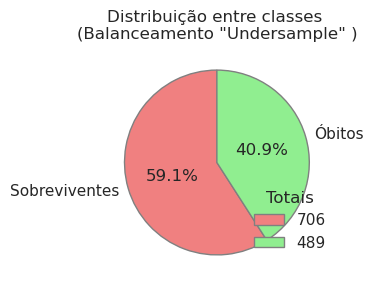

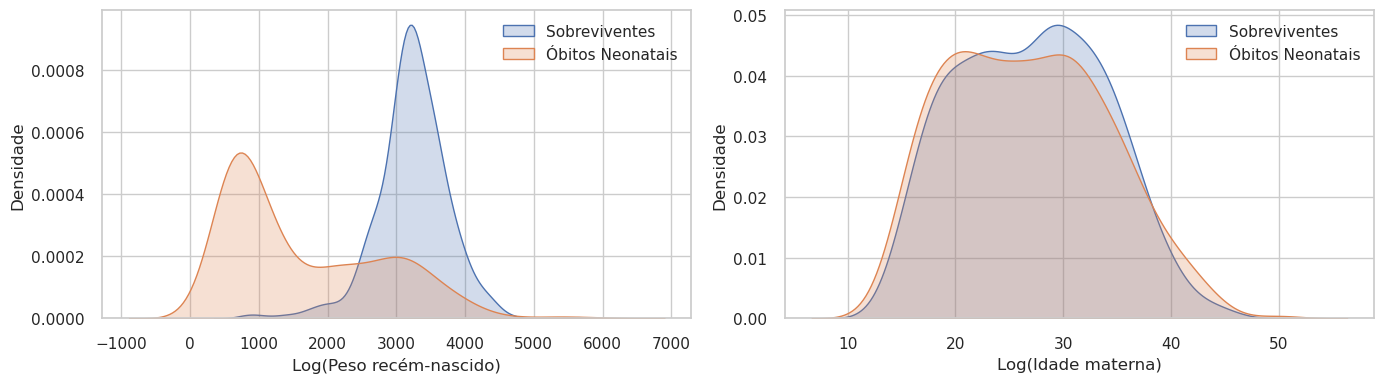

0       1      2
                  Validação  Treino  Teste
sobreviventes         87603     564    142
óbitos neonatais        132     392     97

In [11]:
df_80 = X_80.copy()
df_80['OBITO_NEONATAL'] = y_80.copy()

df_class_0 = df_80[df_80['OBITO_NEONATAL'] == 0].copy()
X_class_0 = df_class_0.drop(columns=['OBITO_NEONATAL']).copy()
y_class_0 = df_class_0['OBITO_NEONATAL'].copy()

df_class_1 = df_80[df_80['OBITO_NEONATAL'] == 1].copy()
X_class_1 = df_class_1.drop(columns=['OBITO_NEONATAL']).copy()
y_class_1 = df_class_1['OBITO_NEONATAL'].copy()

# Separação de ~1% da classe 0 pra balanceamento
X_bal, X_val_bal, y_bal, y_val_bal = train_test_split(X_class_0, y_class_0, test_size=0.99, random_state=42)

X_bal = pd.concat([X_bal, X_class_1])
y_bal = pd.concat([y_bal, y_class_1])

X_val_bal = pd.concat([X_val_bal, X_val])
y_val_bal = pd.concat([y_val_bal, y_val])

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.20, random_state=42)

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val_bal.value_counts()[0], y_train_bal.value_counts()[0], y_test_bal.value_counts()[0]],
        'óbitos neonatais': [y_val_bal.value_counts()[1], y_train_bal.value_counts()[1], y_test_bal.value_counts()[1]]}

pizza(pd.concat([X_bal, y_bal], axis=1), '\n(Balanceamento "Undersample" )')
peso_distro(X_bal, y_bal)
pd.DataFrame(data).T.to_csv('dados_undersample.csv', header=False)
pd.DataFrame(data).T

## 1.3) Dados para abordagem de treinamento com classe única (SVM one class / Isolation Forest)

In [12]:
# Separate data into class 0 and class 1
class_0_data = df_80[df_80['OBITO_NEONATAL'] == 0].copy()
class_1_data = df_80[df_80['OBITO_NEONATAL'] == 1].copy()

# Remove target
class_0_data = class_0_data.drop(columns=['OBITO_NEONATAL']).copy()
class_1_data = class_1_data.drop(columns=['OBITO_NEONATAL']).copy()

# Conjunto Treino e teste apenas Classe 0
X_train_class0, X_test_class0 = train_test_split(class_0_data, test_size=0.1, random_state=42)
X_outliers = class_1_data.copy()
y_outliers = np.ones(len(X_outliers), dtype=int)

X_test_both = np.concatenate((X_train_class0, X_outliers))
y_test_both = np.concatenate((np.zeros(len(X_train_class0), dtype=int), np.ones(len(X_outliers), dtype=int)))

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val.value_counts()[0], X_train_class0.shape[0], X_test_class0.shape[0]],
        'óbitos neonatais': [X_outliers.shape[0], 0,0 ]}

pd.DataFrame(data).T.to_csv('dados_ONE_CLASS.csv', header=False)
pd.DataFrame(data).T

0       1      2
                  Validação  Treino  Teste
sobreviventes         17654   63589   7066
óbitos neonatais        489       0      0

## 1.4) Aplicação da técnica ENN para balanceamento "Undersample"

A técnica Edited Nearest Neighbours (ENN) é uma abordagem de subamostragem que visa identificar e remover instâncias potencialmente problemáticas de um conjunto de dados desequilibrado. Ao avaliar cada ponto de dados, o ENN examina a classe de seus vizinhos mais próximos, determinando se esses pontos são consistentes ou discordantes. Em particular, o ENN analisa a classe de cada instância e a compara com a classe de seus vizinhos mais próximos. Se a maioria dos vizinhos mais próximos de uma instância pertence a uma classe diferente da sua, ela é considerada potencialmente ruidosa e é removida do conjunto de dados.

Esta técnica utiliza a distância euclidiana ou outra métrica de distância para identificar vizinhos mais próximos. Ao remover instâncias inconsistentes, o ENN busca melhorar a qualidade do conjunto de dados de treinamento, removendo informações redundantes ou contraditórias que podem prejudicar o processo de aprendizado do modelo. No entanto, é essencial considerar o impacto da remoção de instâncias em conjunto com o equilíbrio entre as classes e a perda potencial de informações importantes.

Existem várias abordagens para lidar com conjuntos de dados desbalanceadas. Vamos aplicar duas estratégias para fins de comparação e análise. A primeira delas será aplicar uma técnica para reduzir o número de amostras da classe majoritária, conhecida como "undersample". Vamos aplicar duas estratégias, a primeira fazendo uma redução por amostragem, o que preserva a distribuição dos dados, porém podendo descartar amostras relevantes, e outra um método sistematico, que será a técnica de Edited Nearest Neighbours (ENN).

Está técnica apresenta vantagens substanciais em relação ao undersample aleatório em contextos de conjuntos de dados desequilibrados. Ao remover seletivamente exemplos que estão próximos das fronteiras das classes, o ENN preserva informações cruciais enquanto reduz o viés de classe. Isso resulta em uma distribuição de dados mais fiel à original, o que é crucial para manter a representatividade das classes e evitar a perda de informações críticas. Além disso, o ENN mitiga o impacto no desempenho do modelo ao manter uma quantidade significativa de dados, permitindo que o modelo aprenda relações mais precisas entre as classes. Esta abordagem oferece um equilíbrio entre a redução de dados e a preservação de informações valiosas, tornando-o uma ferramenta eficaz para lidar com o desbalanceamento de conjuntos de dados.

In [13]:

file_path = folder + 'X_enn.pkl'

# Ler os arrays de arquivos pickle caso existam
if os.path.exists(file_path):
  with open(folder + 'X_enn.pkl', 'rb') as file:
      X_enn = pickle.load(file)

  with open(folder + 'y_enn.pkl', 'rb') as file:
      y_enn = pickle.load(file)

  # Indices para tratar registros exlcuídos como dados de testes
  with open(folder + 'enn_sample_indices.pkl', 'rb') as file:
      enn_sample_indices = pickle.load(file)
# Caso não existam, gerar e salvar
else:
  enn = EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=500)
  X_enn, y_enn = enn.fit_resample(X_80, y_80)

  # Salvar os arrays em arquivos pickle
  with open(folder + 'X_enn.pkl', 'wb') as file:
      pickle.dump(X_enn, file)

  with open(folder + 'y_enn.pkl', 'wb') as file:
      pickle.dump(y_enn, file)

  # Indices para tratar registros exlcuídos como dados de testes
  with open(folder + 'enn_sample_indices.pkl', 'wb') as file:
      pickle.dump(enn.sample_indices_, file)
      enn_sample_indices = enn.sample_indices_


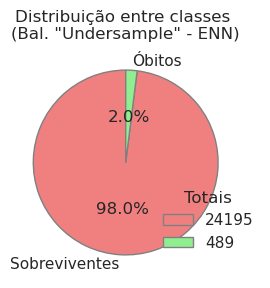

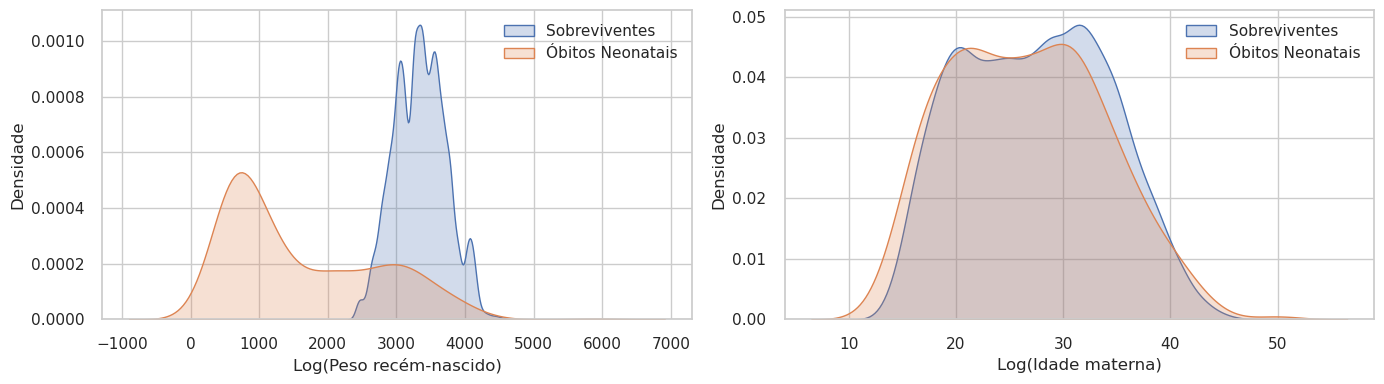

0       1      2
                  Validação  Treino  Teste
sobreviventes         64114   19360   4835
óbitos neonatais        132     387    102

In [14]:
# Separação do conjunto de dados em dados de treinamento e teste em proporção 80/20
X_train_enn, X_test_enn, y_train_enn, y_test_enn = train_test_split(X_enn, y_enn, test_size=0.20, random_state=42)

X_val_enn = X_80.drop(index=X_80.index[enn_sample_indices]).copy()
y_val_enn = y_80.drop(index=y_80.index[enn_sample_indices]).copy()

X_val_enn = pd.concat([X_val_enn.copy(), X_val.copy()])
y_val_enn = pd.concat([y_val_enn.copy(), y_val.copy()])

data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val_enn.value_counts()[0], y_train_enn.value_counts()[0], y_test_enn.value_counts()[0]],
        'óbitos neonatais': [y_val_enn.value_counts()[1], y_train_enn.value_counts()[1], y_test_enn.value_counts()[1]]}

pizza(pd.concat([X_enn, y_enn], axis=1), '\n(Bal. "Undersample" - ENN)')
peso_distro(X_train_enn, y_train_enn)
pd.DataFrame(data).T.to_csv('dados_undersample_ENN.csv', header=False)
pd.DataFrame(data).T


## 1.5) Balanceamento "Oversample" ADASUYN

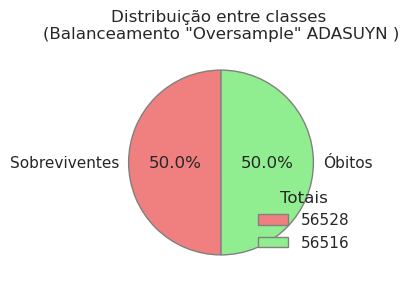

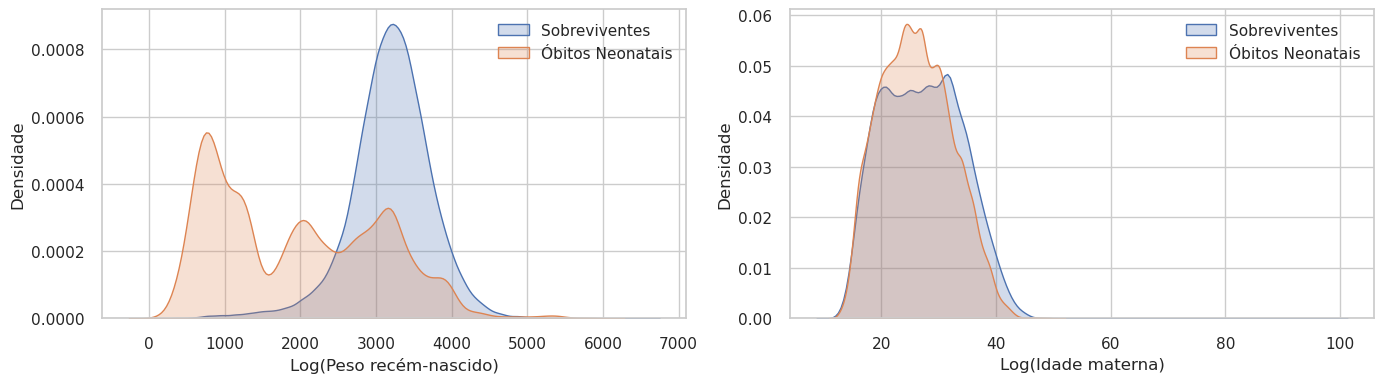

0       1      2
                  Validação  Treino  Teste
sobreviventes         17654   56528  14127
óbitos neonatais        132   56516    102

In [15]:
adasyn = ADASYN(sampling_strategy='minority')
X_over, y_over = adasyn.fit_resample(X_train, y_train)


data = {'': ['Validação', 'Treino', 'Teste'],
        'sobreviventes': [y_val.value_counts()[0], y_over.value_counts()[0], y_test.value_counts()[0]],
        'óbitos neonatais': [y_val.value_counts()[1], y_over.value_counts()[1], y_test.value_counts()[1]]}

pizza(pd.concat([X_over, y_over], axis=1), '\n(Balanceamento "Oversample" ADASUYN )')
peso_distro(X_over, y_over)
pd.DataFrame(data).T.to_csv('dados_oversample_ADASUYN.csv', header=False)
pd.DataFrame(data).T


## 1.6) Normalização de features

In [16]:
# Store the feature names before scaling
feature_names = X_80.columns.tolist()

file_path = folder + 'X_train.pkl'

# Ler os arrays de arquivos pickle caso existam
if os.path.exists(file_path):
  # Load Base 80/20
  with open(folder + 'X_train.pkl', 'rb') as f:
      X_train = pickle.load(f)

  with open(folder + 'X_test.pkl', 'rb') as f:
      X_test = pickle.load(f)

  with open(folder + 'X_val.pkl', 'rb') as f:
      X_val = pickle.load(f)

  # Load Base balanceada Undersampling
  with open(folder + 'X_train_bal.pkl', 'rb') as f:
      X_train_bal = pickle.load(f)

  with open(folder + 'X_test_bal.pkl', 'rb') as f:
      X_test_bal = pickle.load(f)

  with open(folder + 'X_val_bal.pkl', 'rb') as f:
      X_val_bal = pickle.load(f)

  # Load Base balanceada Undersampling ENN
  with open(folder + 'X_train_enn.pkl', 'rb') as f:
      X_train_enn = pickle.load(f)

  with open(folder + 'X_test_enn.pkl', 'rb') as f:
      X_test_enn = pickle.load(f)

  with open(folder + 'X_val_enn.pkl', 'rb') as f:
      X_val_enn = pickle.load(f)

  with open(folder + 'X_over.pkl', 'rb') as f:
      X_over = pickle.load(f)

  with open(folder + 'y_over.pkl', 'rb') as f:
      y_over = pickle.load(f)

  # ONE CLASS
  with open(folder + 'X_train_class0.pkl', 'rb') as f:
      X_train_class0 = pickle.load(f)
 
  with open(folder + 'X_test_class0.pkl', 'rb') as f:
      X_test_class0 = pickle.load(f)
 
  with open(folder + 'X_outliers.pkl', 'rb') as f:
      X_outliers = pickle.load(f)

  with open(folder + 'X_test_both.pkl', 'rb') as f:
      X_test_both = pickle.load(f)

# Caso não exista, normaliza e cria os arquivos
else:
  # Normalização
  scaler = MinMaxScaler()

  # Base 80/20
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)
  X_val = scaler.fit_transform(X_val)

  # Base balanceada Undersampling
  X_train_bal = scaler.fit_transform(X_train_bal)
  X_test_bal = scaler.fit_transform(X_test_bal)
  X_val_bal = scaler.fit_transform(X_val_bal)

  # Base balanceada Undersampling ENN
  X_train_enn = scaler.fit_transform(X_train_enn)
  X_test_enn = scaler.fit_transform(X_test_enn)
  X_val_enn = scaler.fit_transform(X_val_enn)

  X_over = scaler.fit_transform(X_over)

  # Dados para abordagem ONE CLASS
  X_train_class0 = scaler.fit_transform(X_train_class0)
  X_test_class0 = scaler.fit_transform(X_test_class0)
  X_outliers = scaler.fit_transform(X_outliers)
  X_test_both = scaler.fit_transform(X_test_both)

  # Salvando dados em Pickles ......

  with open(folder + 'X_train.pkl', 'wb') as f:
      pickle.dump(X_train, f)

  with open(folder + 'X_test.pkl', 'wb') as f:
      pickle.dump(X_test, f)

  with open(folder + 'X_val.pkl', 'wb') as f:
      pickle.dump(X_val, f)

  # Save Base balanceada Undersampling
  with open(folder + 'X_train_bal.pkl', 'wb') as f:
      pickle.dump(X_train_bal, f)

  with open(folder + 'X_test_bal.pkl', 'wb') as f:
      pickle.dump(X_test_bal, f)

  with open(folder + 'X_val_bal.pkl', 'wb') as f:
      pickle.dump(X_val_bal, f)

  # Save Base balanceada Undersampling ENN
  with open(folder + 'X_train_enn.pkl', 'wb') as f:
      pickle.dump(X_train_enn, f)

  with open(folder + 'X_test_enn.pkl', 'wb') as f:
      pickle.dump(X_test_enn, f)

  with open(folder + 'X_val_enn.pkl', 'wb') as f:
      pickle.dump(X_val_enn, f)
  
  with open(folder + 'X_over.pkl', 'wb') as f:
      pickle.dump(X_over, f)

  with open(folder + 'y_over.pkl', 'wb') as f:
      pickle.dump(y_over, f)

  with open(folder + 'X_train_class0.pkl', 'wb') as f:
      pickle.dump(X_train_class0, f)

  with open(folder + 'X_test_class0.pkl', 'wb') as f:
      pickle.dump(X_test_class0, f)

  with open(folder + 'X_outliers.pkl', 'wb') as f:
      pickle.dump(X_outliers, f)

  with open(folder + 'X_test_both.pkl', 'wb') as f:
      pickle.dump(X_test_both, f)


# CHECKPOINT 1 -> EXPERIMENTOS

Os experimentos envolveram quatro conjuntos de algoritmos de aprendizado de máquina. Inicialmente, foram conduzidos experimentos utilizando regressão logística para estabelecer um modelo de referência. A regressão logística é uma técnica estatística que modela a probabilidade de ocorrência de um evento. Em seguida, prosseguimos com experimentos empregando o algoritmo Naive Bayes, um método probabilístico baseado no teorema de Bayes, especialmente eficaz em problemas de classificação de texto.

Posteriormente, aplicamos o algoritmo XGBoost, uma implementação otimizada de boosting que utiliza árvores de decisão, destacando-se pela eficiência em problemas complexos e grande quantidade de dados. Por fim, adotamos a abordagem oneclass, utilizando os algoritmos de SVM (Support Vector Machine) e Isolation Forest. O SVM é conhecido por separar dados em diferentes classes, sendo utilizado na detecção de anomalias quando treinado com exemplos normais. O Isolation Forest, por sua vez, é um algoritmo baseado em árvores projetado para isolar anomalias de forma eficiente em conjuntos de dados extensos. Essa diversidade de algoritmos permite explorar diferentes abordagens e maximizar a eficácia na resolução de problemas específicos.

# E1: Regressão Logística

#### **Descrição**


Este código realiza a classificação usando um modelo de regressão logística simples, avalia o desempenho do modelo e gera visualizações para a curva ROC, a importância das features e os valores SHAP.

O código começa dividindo o conjunto de dados em conjuntos de treinamento e teste, essenciais para avaliar o desempenho do modelo. Em seguida, ele cria um modelo de classificação de Regressão Logística, que é um método amplamente utilizado para problemas de classificação binária. O modelo é treinado usando os dados de treinamento e usado para fazer previsões nos dados de teste.

Avaliando o desempenho, o código calcula a acurácia do modelo, que é a proporção de previsões corretas em relação ao total de previsões. Também calcula a Área sob a Curva ROC (AUC-ROC), que mede a capacidade do modelo de distinguir entre classes positivas e negativas. Os resultados são satisfatórios se a acurácia for alta e o AUC-ROC estiver próximo de 1, indicando que o modelo está fazendo previsões precisas.

Além disso, o código gera gráficos informativos. A curva ROC mostra o equilíbrio entre a taxa de falsos positivos e a taxa de verdadeiros positivos, enquanto o gráfico de importância das features destaca quais características têm maior influência nas previsões do modelo. Por fim, os valores SHAP são calculados para explicar a contribuição de cada feature em cada previsão.

Em resumo, o código apresenta um modelo de Regressão Logística para classificação binária e avalia seu desempenho usando métricas como acurácia e AUC-ROC, ao mesmo tempo em que fornece insights visuais sobre a importância das features e os valores SHAP. Estas análises são fundamentais para entender como o modelo toma suas decisões e quais características são mais relevantes para as previsões.

## E1-a: Regressão Logística - Baseline

O modelo de Regressão Logística foi inicialmente criado com todos os parâmetros configurados com valores padrão. Para que o modelo pudesse convergir para a solução ótima, foi necessário ajustar o parâmetro "max_iter" para o valor de 1.000. Este parâmetro determina o número máximo de iterações que o algoritmo utilizará para convergir para uma solução, ou seja, define o limite de vezes que o algoritmo ajustará os coeficientes do modelo para otimizar a função de custo e encontrar os parâmetros que melhor se ajustam aos dados de treinamento.

Caso o algoritmo não atinja uma solução dentro do número especificado de iterações, uma mensagem de aviso de não convergência pode ser gerada. Aumentar o valor de "max_iter" pode resolver esse problema, permitindo que o algoritmo execute mais iterações na tentativa de encontrar uma solução adequada.

Entretanto, é essencial equilibrar o valor de "max_iter", pois um valor muito alto pode significativamente aumentar o tempo de treinamento do modelo, especialmente em conjuntos de dados grandes. Em resumo, o parâmetro "max_iter" desempenha um papel crucial no controle da convergência da regressão logística e deve ser ajustado de acordo com a complexidade do problema e os recursos computacionais disponíveis.

-------------------------------------------------------------
E1-a : Regressão Logística - Baseline - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       0.99    1.00      1.00    14127
1             1       0.60    0.28      0.39      102
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.80    0.64      0.69    14229
4  weighted avg       0.99    0.99      0.99    14229
-------------------------------------------------------------


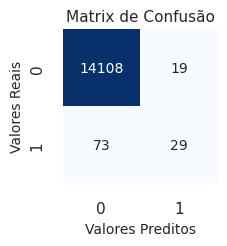

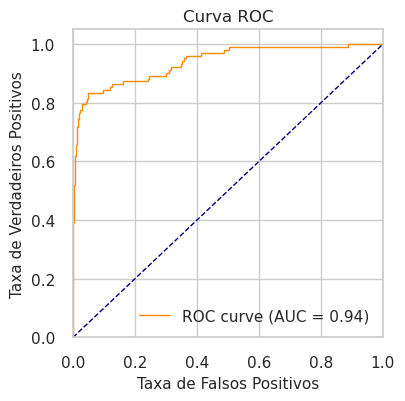

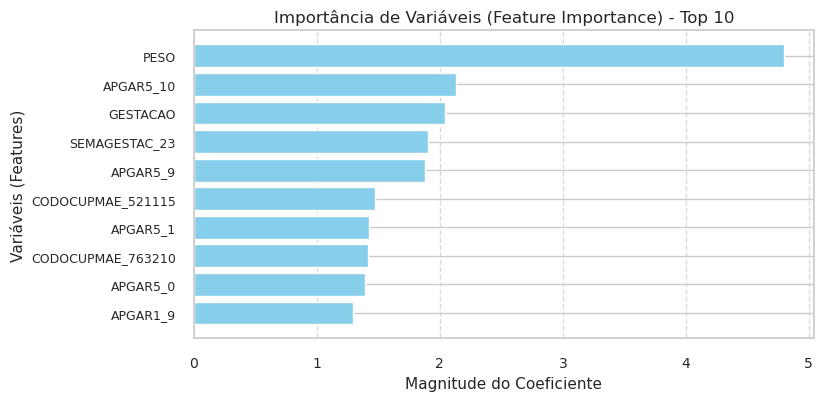

['PESO' 'APGAR5_10' 'GESTACAO' 'SEMAGESTAC_23' 'APGAR5_9'
 'CODOCUPMAE_521115' 'APGAR5_1' 'CODOCUPMAE_763210' 'APGAR5_0' 'APGAR1_9']



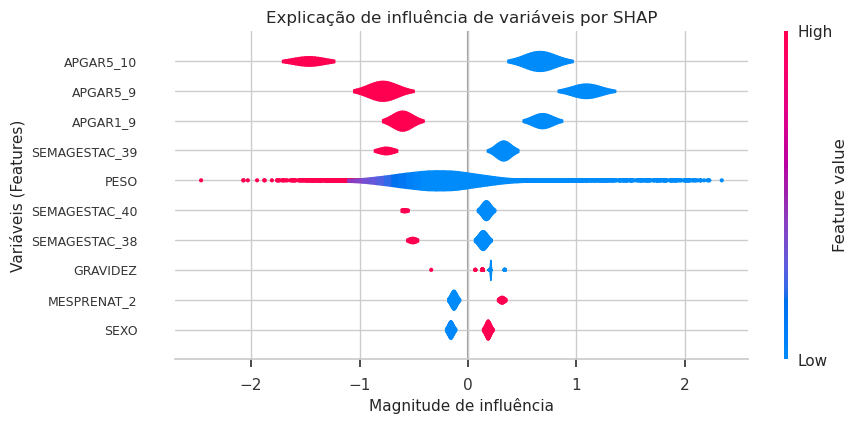

-------------------------------------------------------------
E1-aV: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00    17654
1             1       0.62    0.34      0.44      132
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.81    0.67      0.72    17786
4  weighted avg       0.99    0.99      0.99    17786
-------------------------------------------------------------
Accuracy: 0.9935904644102103
Confusion Matrix
[[17627    27]
 [   87    45]]


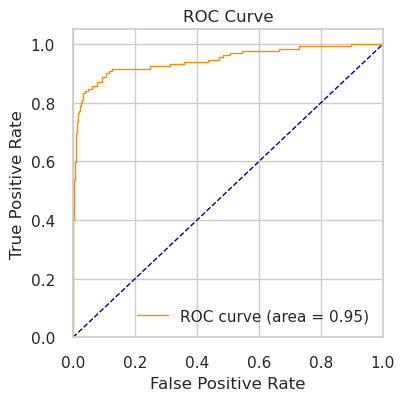

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [17]:
final_report, E1_a = run_experiment('E1-a : Regressão Logística - Baseline',
                              LogisticRegression(random_state=42, max_iter=1000),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)
E1_a.get_params()

## E1-b: Regressão Logística - Balanceamento "Undersample" com amostragem aleatória

#### Simple Plan

-------------------------------------------------------------
E1-b : Regressão Logística - Balanceamento "Undersample" com amostragem aleatória - Base - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.93      0.96    14127
1             1       0.08    0.86      0.15      102
2      accuracy       0.93    0.93      0.93        0
3     macro avg       0.54    0.90      0.56    14229
4  weighted avg       0.99    0.93      0.96    14229
-------------------------------------------------------------


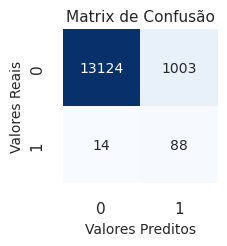

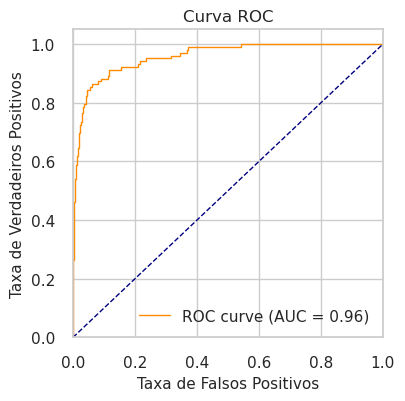

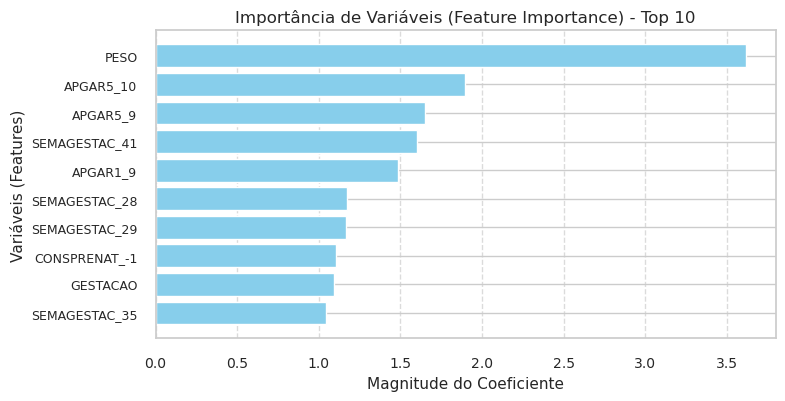

['PESO' 'APGAR5_10' 'APGAR5_9' 'SEMAGESTAC_41' 'APGAR1_9' 'SEMAGESTAC_28'
 'SEMAGESTAC_29' 'CONSPRENAT_-1' 'GESTACAO' 'SEMAGESTAC_35']



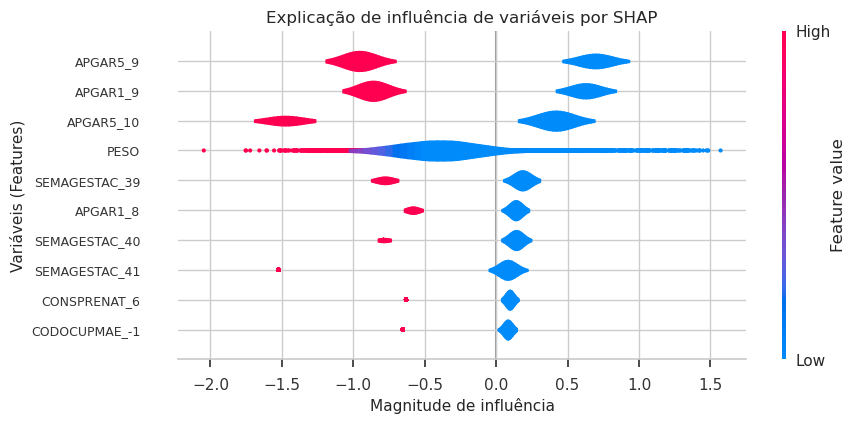

-------------------------------------------------------------
E1-bV: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.90      0.95    17654
1             1       0.06    0.89      0.12      132
2      accuracy       0.90    0.90      0.90        0
3     macro avg       0.53    0.89      0.53    17786
4  weighted avg       0.99    0.90      0.94    17786
-------------------------------------------------------------
Accuracy: 0.9034633981783425
Confusion Matrix
[[15952  1702]
 [   15   117]]


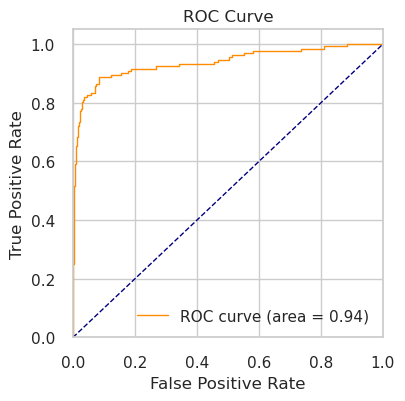

In [18]:
final_report, E1_b = run_experiment('E1-b : Regressão Logística - Balanceamento "Undersample" com amostragem aleatória - Base',
                              LogisticRegression(random_state=42),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

#### Model

-------------------------------------------------------------
E1-b : Regressão Logística - Balanceamento "Undersample" com amostragem aleatória - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.88      0.93    14127
1             1       0.05    0.89      0.09      102
2      accuracy       0.88    0.88      0.88        0
3     macro avg       0.52    0.88      0.51    14229
4  weighted avg       0.99    0.88      0.93    14229
-------------------------------------------------------------


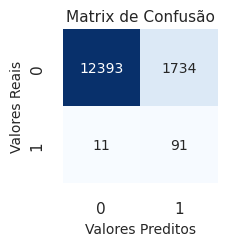

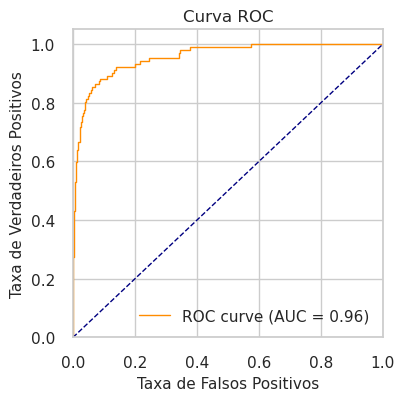

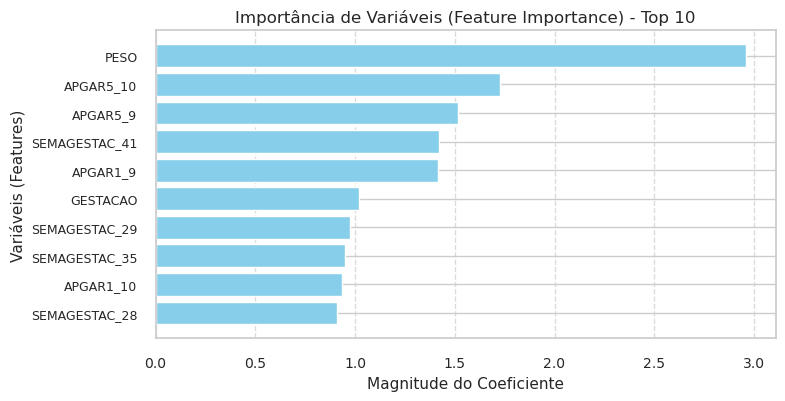

['PESO' 'APGAR5_10' 'APGAR5_9' 'SEMAGESTAC_41' 'APGAR1_9' 'GESTACAO'
 'SEMAGESTAC_29' 'SEMAGESTAC_35' 'APGAR1_10' 'SEMAGESTAC_28']



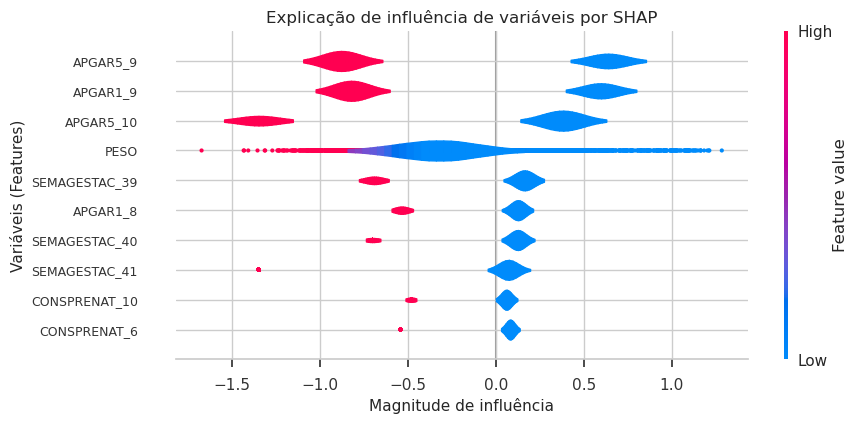

-------------------------------------------------------------
E1-bV: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.84      0.91    17654
1             1       0.04    0.91      0.08      132
2      accuracy       0.84    0.84      0.84        0
3     macro avg       0.52    0.88      0.50    17786
4  weighted avg       0.99    0.84      0.91    17786
-------------------------------------------------------------
Accuracy: 0.8438659619925785
Confusion Matrix
[[14889  2765]
 [   12   120]]


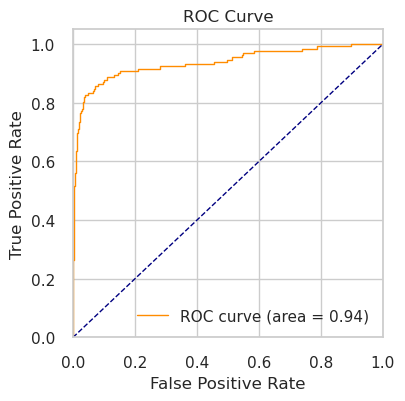

In [19]:
final_report, E1_b = run_experiment('E1-b : Regressão Logística - Balanceamento "Undersample" com amostragem aleatória',
                              LogisticRegression(random_state=42, max_iter=1000, class_weight={0:0.455,1:1}),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

## E1-c: Regressão Logística - Validação Cruzada


#### Simple Plan

In [20]:
#LR = LogisticRegressionCV(random_state=42, max_iter=1000, cv=5).fit(X_train, y_train)
#initial_evaluation(LR, X_val, y_val)

#### Model

Analise ...

In [21]:
# Alto custo computacional
'''
final_report, E1_c= run_experiment('E1-c : Regressão Logística - Validação Cruzada',
                              LogisticRegressionCV(random_state=42, cv=5, # muito pesado...
                                                   multi_class='ovr',
                                                   penalty='l2',
                                                   solver='sag',
                                                   max_iter=1000,# não aumentar pois fica muito pesado
                                                   class_weight={0:1,1:100}),                                                  
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)
E1_c.get_params()
'''

"\nfinal_report, E1_c= run_experiment('E1-c : Regressão Logística - Validação Cruzada',\n                              LogisticRegressionCV(random_state=42, cv=5, # muito pesado...\n                                                   multi_class='ovr',\n                                                   penalty='l2',\n                                                   solver='sag',\n                                                   max_iter=1000,# não aumentar pois fica muito pesado\n                                                   class_weight={0:1,1:100}),                                                  \n                              X_train, y_train, X_test, y_test, X_val, y_val,\n                              final_report)\nE1_c.get_params()\n"

## E1-d: Regressão Logística - Balanceamento "Undersample" ENN

#### Simple Plan

Accuracy: 0.991897913712781
Confusion Matrix
[[4833    2]
 [  38   64]]


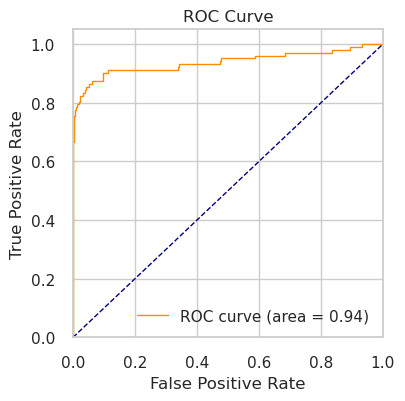

In [22]:
LR = LogisticRegression(random_state=42, max_iter=1000).fit(X_train_enn, y_train_enn)
initial_evaluation(LR, X_test_enn, y_test_enn)

#### Model

Analise ...

-------------------------------------------------------------
E1-d : Regressão Logística - Balanceamento "Undersample" com ENN - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.89      0.94     4835
1             1       0.15    0.88      0.25      102
2      accuracy       0.89    0.89      0.89        0
3     macro avg       0.57    0.89      0.60     4937
4  weighted avg       0.98    0.89      0.93     4937
-------------------------------------------------------------


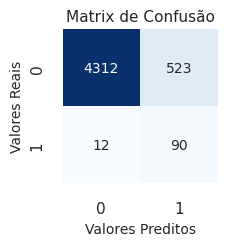

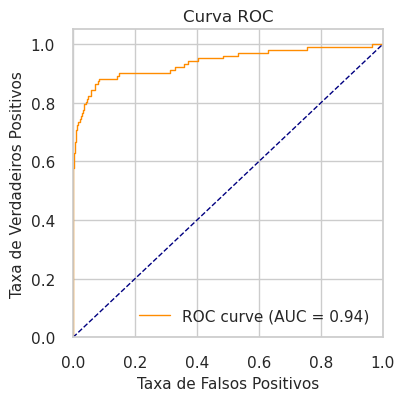

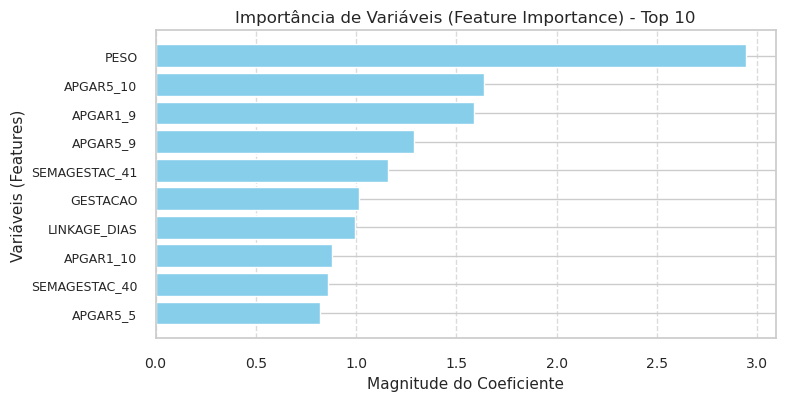

['PESO' 'APGAR5_10' 'APGAR1_9' 'APGAR5_9' 'SEMAGESTAC_41' 'GESTACAO'
 'LINKAGE_DIAS' 'APGAR1_10' 'SEMAGESTAC_40' 'APGAR5_5']



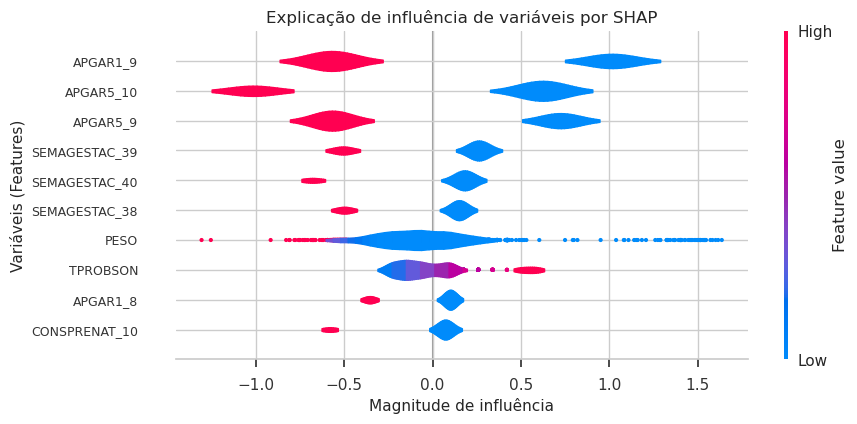

-------------------------------------------------------------
E1-dV: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.79      0.88    17654
1             1       0.03    0.90      0.06      132
2      accuracy       0.79    0.79      0.79        0
3     macro avg       0.51    0.84      0.47    17786
4  weighted avg       0.99    0.79      0.87    17786
-------------------------------------------------------------
Accuracy: 0.7865174856628809
Confusion Matrix
[[13870  3784]
 [   13   119]]


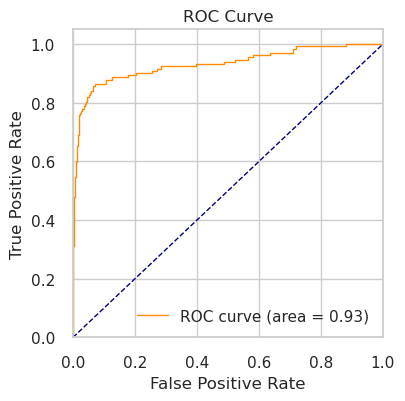

{'C': 1.0,
 'class_weight': {0: 0.455, 1: 1},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [23]:
final_report, E1_d = run_experiment('E1-d : Regressão Logística - Balanceamento "Undersample" com ENN',
                              LogisticRegression(random_state=42,
                                                 max_iter=100, 
                                                 #multi_class='ovr',
                                                 #penalty='l2', 
                                                 #solver='sag',
                                                 class_weight={0:0.009,1:1}
                                                ),
                              X_train_enn, y_train_enn, X_test_enn, y_test_enn, X_val, y_val,
                              final_report)
E1_b.get_params()

## E1-e: Regressão Logística - Ajuste Paramétrico

#### Model

-------------------------------------------------------------
E1-e : Regressão Logística - Ajuste Paramétrico - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.87      0.93    14127
1             1       0.05    0.87      0.09      102
2      accuracy       0.87    0.87      0.87        0
3     macro avg       0.52    0.87      0.51    14229
4  weighted avg       0.99    0.87      0.92    14229
-------------------------------------------------------------


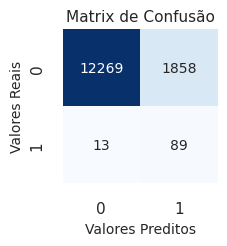

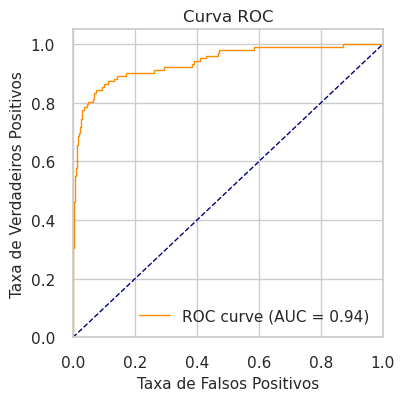

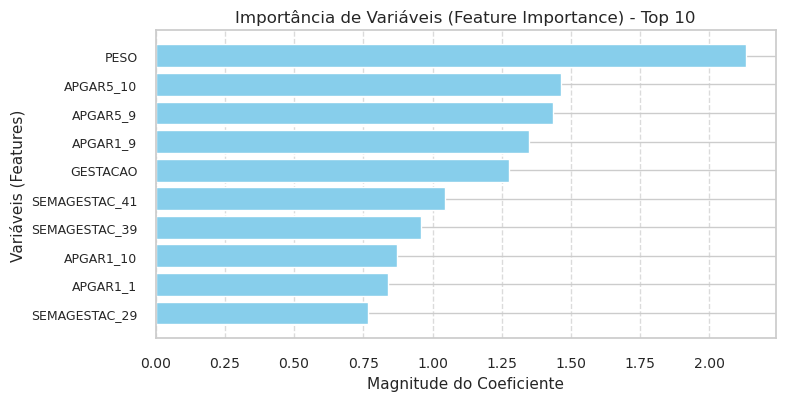

['PESO' 'APGAR5_10' 'APGAR5_9' 'APGAR1_9' 'GESTACAO' 'SEMAGESTAC_41'
 'SEMAGESTAC_39' 'APGAR1_10' 'APGAR1_1' 'SEMAGESTAC_29']



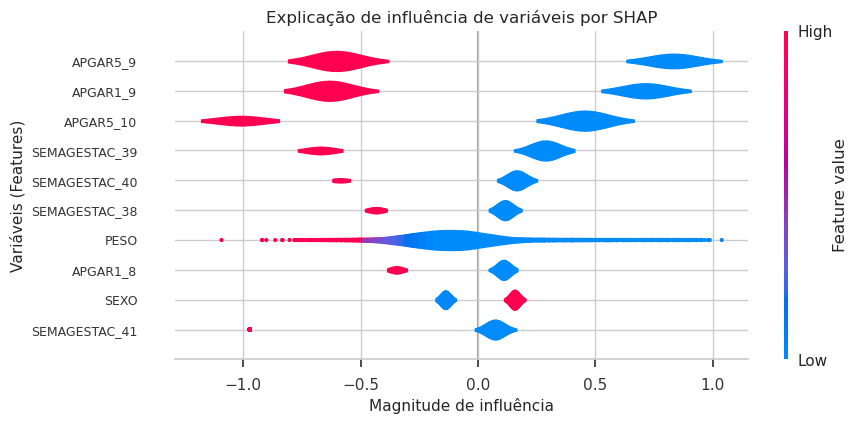

-------------------------------------------------------------
E1-eV: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.84      0.92    17654
1             1       0.04    0.89      0.08      132
2      accuracy       0.84    0.84      0.84        0
3     macro avg       0.52    0.87      0.50    17786
4  weighted avg       0.99    0.84      0.91    17786
-------------------------------------------------------------
Accuracy: 0.8448779939278084
Confusion Matrix
[[14909  2745]
 [   14   118]]


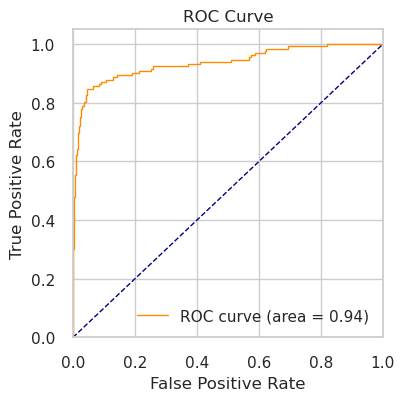

{'C': 1.0,
 'class_weight': {0: 0.003, 1: 1},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [24]:
# Usando solver='sag' deu mesma coisa
final_report, E1_e = run_experiment('E1-e : Regressão Logística - Ajuste Paramétrico',
                           LogisticRegression(random_state=42,  
                                                 max_iter=100,
                                                 class_weight={0:0.003,1:1}),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)
E1_e.get_params()


#### Grid Search

In [25]:
'''
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression()

# Define the grid of parameters to search
param_grid = {
    'solver': ['sag'],  # Solvers for logistic regression
    'penalty': ['l2'],  # Regularization penalty
    'multi_class': ['ovr'],  # Multiclass strategy
    'class_weight': [{0: 1, 1: 1},{0: 5, 1: 1}, {0: 6, 1: 1}, {0: 7, 1: 1}, {0: 8, 1: 1}, {0: 9, 1: 1}, {0: 10, 1: 1},  {0: 20, 1: 1} ],  # Class weights
    'max_iter': [10,50,100,150,200,250,300,350,400,450,500,600,700,800,900]  # Maximum number of iterations
}


# Perform fine-tuning grid search with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Print the results of fine-tuning grid search
print("Fine-Tuning Grid Search Results:")
print("")

# Print the best parameters found by fine-tuning grid search
print("Best Parameters:")
print(grid_search.best_params_)
print("")

# Print the best cross-validation score found by fine-tuning grid search
print("Best Cross-Validation Score:", grid_search.best_score_)
print("")

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
val_score = best_model.score(X_val, y_val)
print("Validation Set Score:", val_score)
'''


'\nfrom sklearn.model_selection import GridSearchCV\n\nlog_reg = LogisticRegression()\n\n# Define the grid of parameters to search\nparam_grid = {\n    \'solver\': [\'sag\'],  # Solvers for logistic regression\n    \'penalty\': [\'l2\'],  # Regularization penalty\n    \'multi_class\': [\'ovr\'],  # Multiclass strategy\n    \'class_weight\': [{0: 1, 1: 1},{0: 5, 1: 1}, {0: 6, 1: 1}, {0: 7, 1: 1}, {0: 8, 1: 1}, {0: 9, 1: 1}, {0: 10, 1: 1},  {0: 20, 1: 1} ],  # Class weights\n    \'max_iter\': [10,50,100,150,200,250,300,350,400,450,500,600,700,800,900]  # Maximum number of iterations\n}\n\n\n# Perform fine-tuning grid search with cross-validation\ngrid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring=\'recall\')\ngrid_search.fit(X_train, y_train)\n\n# Print the results of fine-tuning grid search\nprint("Fine-Tuning Grid Search Results:")\nprint("")\n\n# Print the best parameters found by fine-tuning grid search\nprint("Best Parameters:")\nprint(grid_search.best_params_)\nprint("")

## E1-f: Regressão Logística - Balanceamento "Oversample" ADASYN

#### Simple Plan

Accuracy: 0.9937451683182233
Confusion Matrix
[[14104    23]
 [   66    36]]


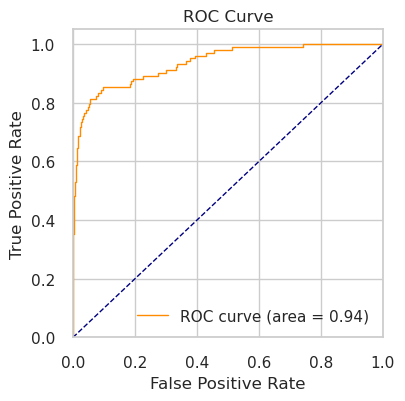

In [26]:
LR = LogisticRegression(random_state=42, max_iter=200).fit(X_over, y_over)
initial_evaluation(LR, X_test, y_test)

#### Model

-------------------------------------------------------------
E1-f: Balanceamento "Oversample" ADASYN - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.85      0.92    14127
1             1       0.04    0.87      0.08      102
2      accuracy       0.85    0.85      0.85        0
3     macro avg       0.52    0.86      0.50    14229
4  weighted avg       0.99    0.85      0.91    14229
-------------------------------------------------------------


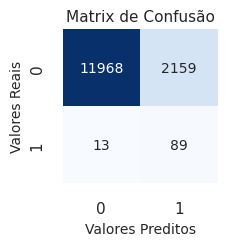

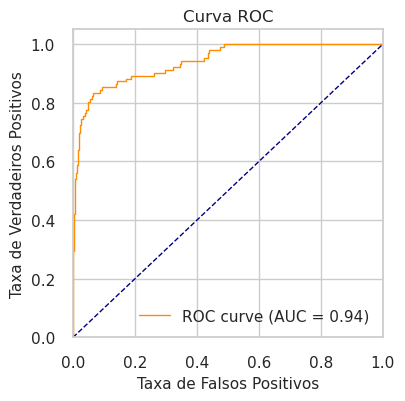

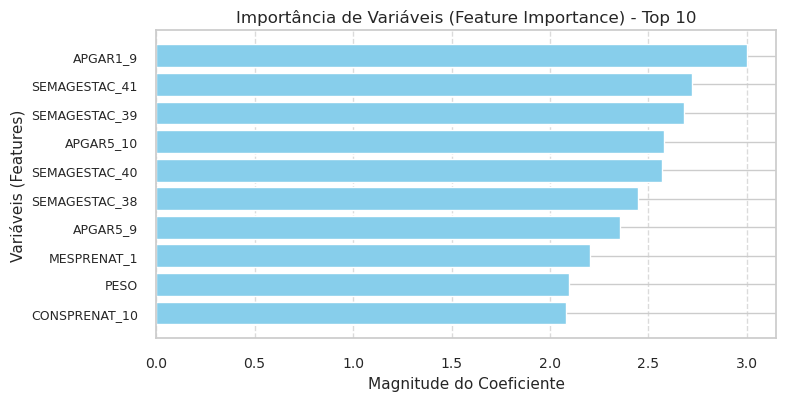

['APGAR1_9' 'SEMAGESTAC_41' 'SEMAGESTAC_39' 'APGAR5_10' 'SEMAGESTAC_40'
 'SEMAGESTAC_38' 'APGAR5_9' 'MESPRENAT_1' 'PESO' 'CONSPRENAT_10']



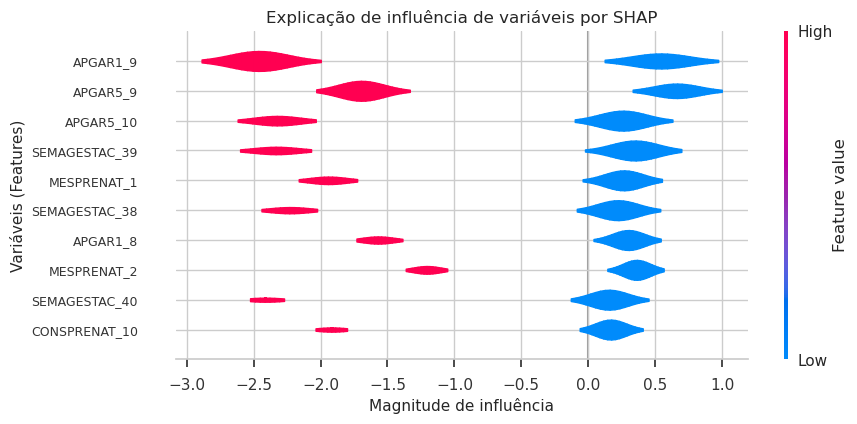

-------------------------------------------------------------
E1-fV: Validação - LogisticRegression
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.83      0.91    17654
1             1       0.04    0.90      0.07      132
2      accuracy       0.83    0.83      0.83        0
3     macro avg       0.52    0.86      0.49    17786
4  weighted avg       0.99    0.83      0.90    17786
-------------------------------------------------------------
Accuracy: 0.8287417069605307
Confusion Matrix
[[14621  3033]
 [   13   119]]


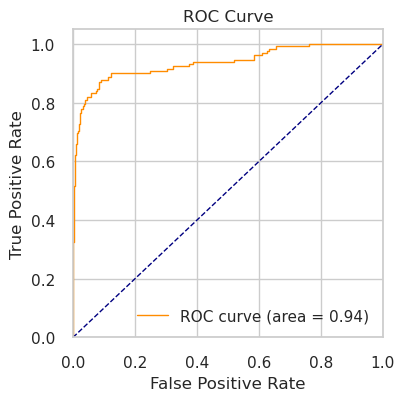

{'C': 1.0,
 'class_weight': {0: 0.005, 1: 1},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 200,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [27]:
final_report, E1_f = run_experiment('E1-f: Balanceamento "Oversample" ADASYN',
                              LogisticRegression(random_state=42, max_iter=200,
                                                 #solver='sag', penalty='l2', 
                                                 class_weight={0:0.005,1:1}
                                                ),
                                                X_over, y_over, X_test, y_test, X_val, y_val,
                                                final_report)
E1_f.get_params()


# E2: Naive Bayes

## E2-a: Modelo Naive Bayes - ComplementNB - Baseline


-------------------------------------------------------------
E2-a : Naive Bayes - ComplementNB - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.95      0.97    14127
1             1       0.11    0.80      0.19      102
2      accuracy       0.95    0.95      0.95        0
3     macro avg       0.55    0.88      0.58    14229
4  weighted avg       0.99    0.95      0.97    14229
-------------------------------------------------------------


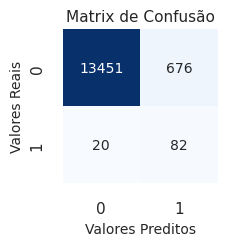

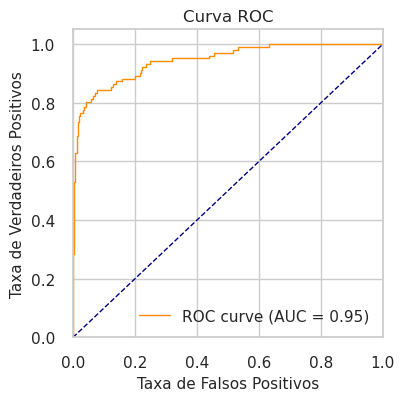

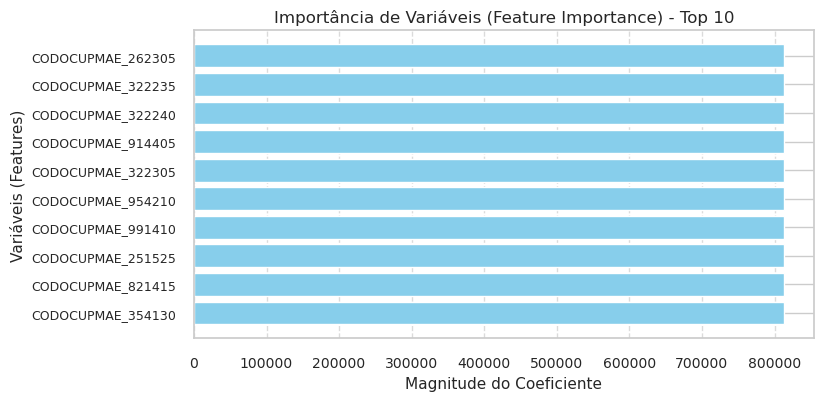

['CODOCUPMAE_262305' 'CODOCUPMAE_322235' 'CODOCUPMAE_322240'
 'CODOCUPMAE_914405' 'CODOCUPMAE_322305' 'CODOCUPMAE_954210'
 'CODOCUPMAE_991410' 'CODOCUPMAE_251525' 'CODOCUPMAE_821415'
 'CODOCUPMAE_354130']

-------------------------------------------------------------
E2-aV: Validação - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.95      0.98    17654
1             1       0.12    0.83      0.21      132
2      accuracy       0.95    0.95      0.95        0
3     macro avg       0.56    0.89      0.59    17786
4  weighted avg       0.99    0.95      0.97    17786
-------------------------------------------------------------
Accuracy: 0.9533903069830204
Confusion Matrix
[[16847   807]
 [   22   110]]


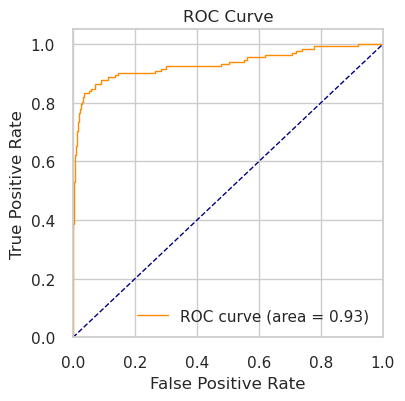

In [28]:
final_report, E2_a = run_experiment('E2-a : Naive Bayes - ComplementNB',
                              ComplementNB(),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)


## E2-b: Modelo Naive Bayes - ComplementNB - Ajuste Fino


-------------------------------------------------------------
E2-b : Naive Bayes - ComplementNB - Ajuste Fino - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.94      0.97    14127
1             1       0.09    0.81      0.16      102
2      accuracy       0.94    0.94      0.94        0
3     macro avg       0.54    0.88      0.56    14229
4  weighted avg       0.99    0.94      0.96    14229
-------------------------------------------------------------


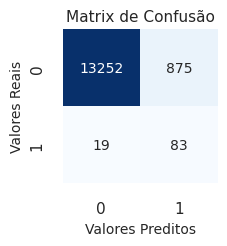

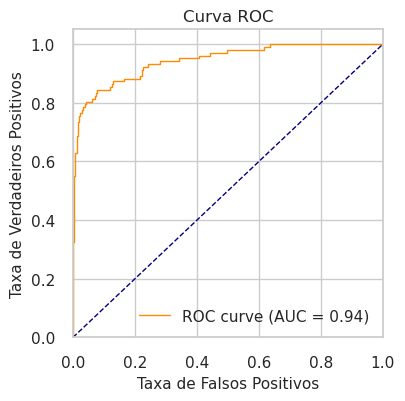

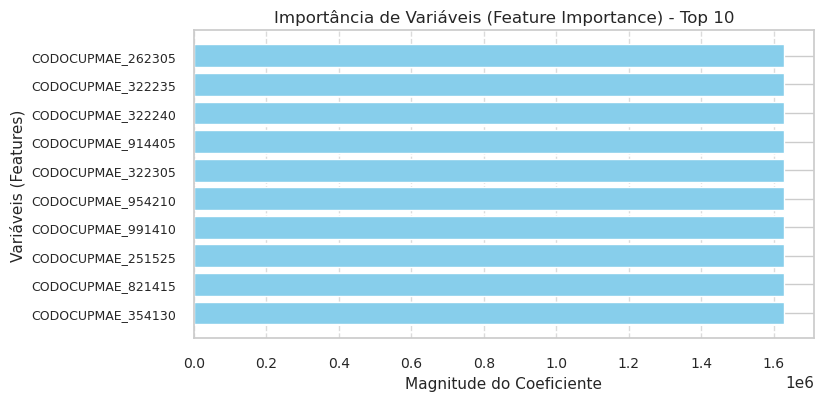

['CODOCUPMAE_262305' 'CODOCUPMAE_322235' 'CODOCUPMAE_322240'
 'CODOCUPMAE_914405' 'CODOCUPMAE_322305' 'CODOCUPMAE_954210'
 'CODOCUPMAE_991410' 'CODOCUPMAE_251525' 'CODOCUPMAE_821415'
 'CODOCUPMAE_354130']

-------------------------------------------------------------
E2-bV: Validação - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.94      0.97    17654
1             1       0.10    0.85      0.17      132
2      accuracy       0.94    0.94      0.94        0
3     macro avg       0.55    0.89      0.57    17786
4  weighted avg       0.99    0.94      0.96    17786
-------------------------------------------------------------
Accuracy: 0.9395029798718093
Confusion Matrix
[[16598  1056]
 [   20   112]]


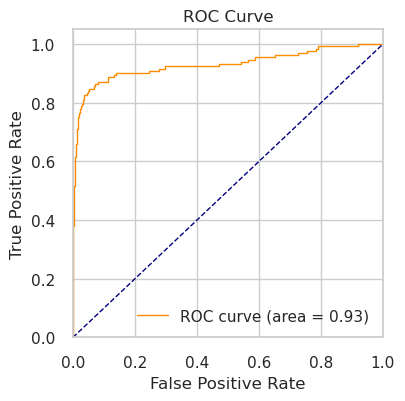

In [29]:
final_report, E2_b = run_experiment('E2-b : Naive Bayes - ComplementNB - Ajuste Fino',
                              ComplementNB(alpha=0.499),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)


-------------------------------------------------------------
E2-b : Naive Bayes - ComplementNB - Ajuste Fino - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.89      0.94    14127
1             1       0.05    0.85      0.10      102
2      accuracy       0.89    0.89      0.89        0
3     macro avg       0.53    0.87      0.52    14229
4  weighted avg       0.99    0.89      0.93    14229
-------------------------------------------------------------


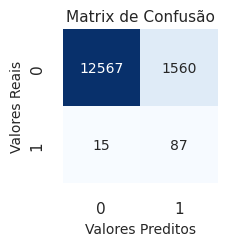

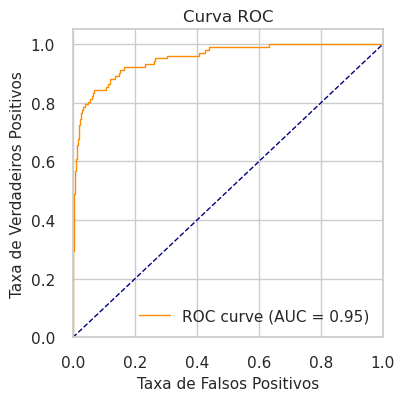

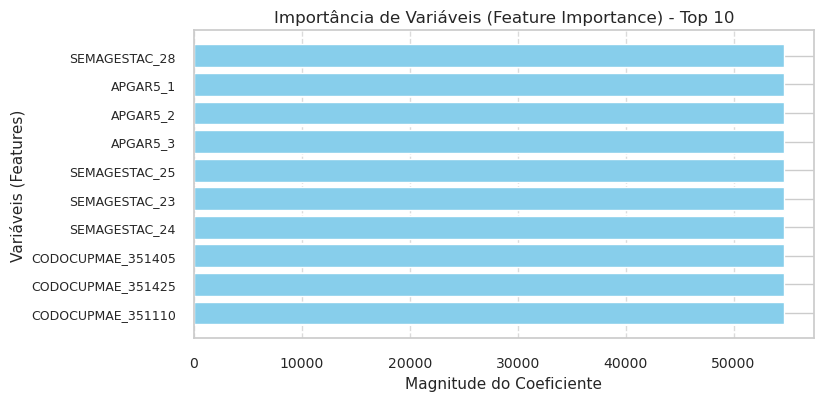

['SEMAGESTAC_28' 'APGAR5_1' 'APGAR5_2' 'APGAR5_3' 'SEMAGESTAC_25'
 'SEMAGESTAC_23' 'SEMAGESTAC_24' 'CODOCUPMAE_351405' 'CODOCUPMAE_351425'
 'CODOCUPMAE_351110']

-------------------------------------------------------------
E2-bV: Validação - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.85      0.92    17654
1             1       0.04    0.89      0.08      132
2      accuracy       0.85    0.85      0.85        0
3     macro avg       0.52    0.87      0.50    17786
4  weighted avg       0.99    0.85      0.91    17786
-------------------------------------------------------------
Accuracy: 0.8510626335319914
Confusion Matrix
[[15019  2635]
 [   14   118]]


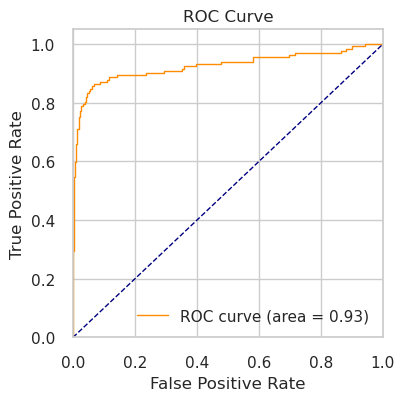

In [30]:
# Balanceado
final_report, E2_b = run_experiment('E2-b : Naive Bayes - ComplementNB - Ajuste Fino',
                              ComplementNB(alpha=0.15),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

-------------------------------------------------------------
E2-b : Naive Bayes - ComplementNB - Ajuste Fino - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.99      0.99    14127
1             1       0.34    0.61      0.43      102
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.67    0.80      0.71    14229
4  weighted avg       0.99    0.99      0.99    14229
-------------------------------------------------------------


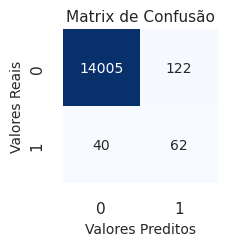

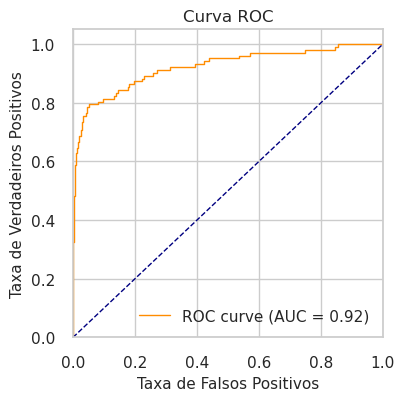

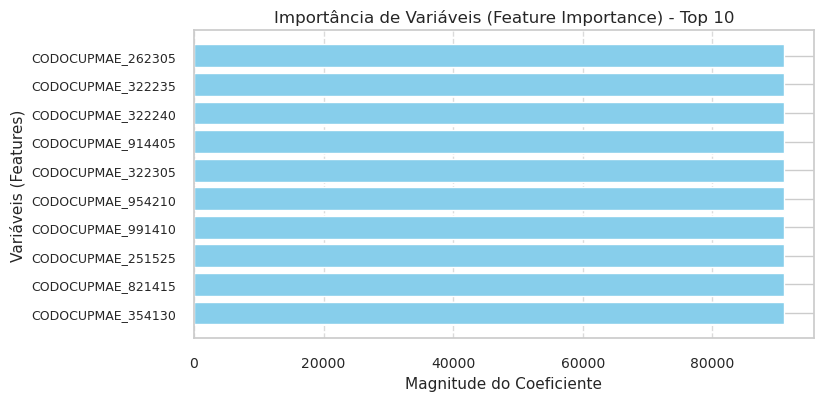

['CODOCUPMAE_262305' 'CODOCUPMAE_322235' 'CODOCUPMAE_322240'
 'CODOCUPMAE_914405' 'CODOCUPMAE_322305' 'CODOCUPMAE_954210'
 'CODOCUPMAE_991410' 'CODOCUPMAE_251525' 'CODOCUPMAE_821415'
 'CODOCUPMAE_354130']

-------------------------------------------------------------
E2-bV: Validação - ComplementNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.99      0.99    17654
1             1       0.31    0.58      0.40      132
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.65    0.78      0.70    17786
4  weighted avg       0.99    0.99      0.99    17786
-------------------------------------------------------------
Accuracy: 0.9874058248060272
Confusion Matrix
[[17486   168]
 [   56    76]]


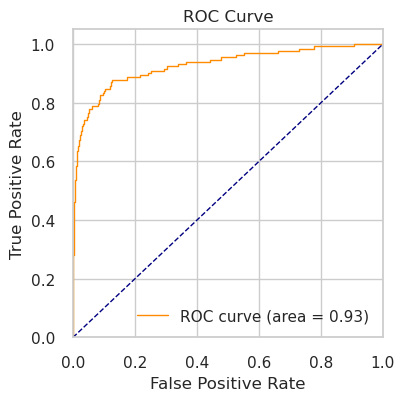

In [31]:
# Balanceado Oversample
final_report, E2_bo = run_experiment('E2-b : Naive Bayes - ComplementNB - Ajuste Fino',
                              ComplementNB(alpha=9),
                              X_over, y_over, X_test, y_test, X_val, y_val,
                              final_report)

## E2-c: Modelo Naive Bayes - MultinomialNB - Ajuste Fino


#### Simple Plan

-------------------------------------------------------------
E2-c : Naive Bayes - MultinomialNB - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.99      1.00    14127
1             1       0.40    0.56      0.46      102
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.70    0.78      0.73    14229
4  weighted avg       0.99    0.99      0.99    14229
-------------------------------------------------------------


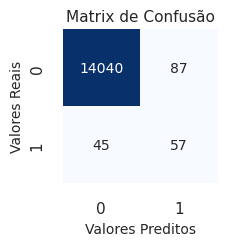

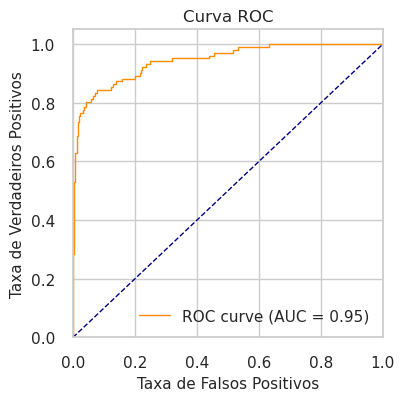

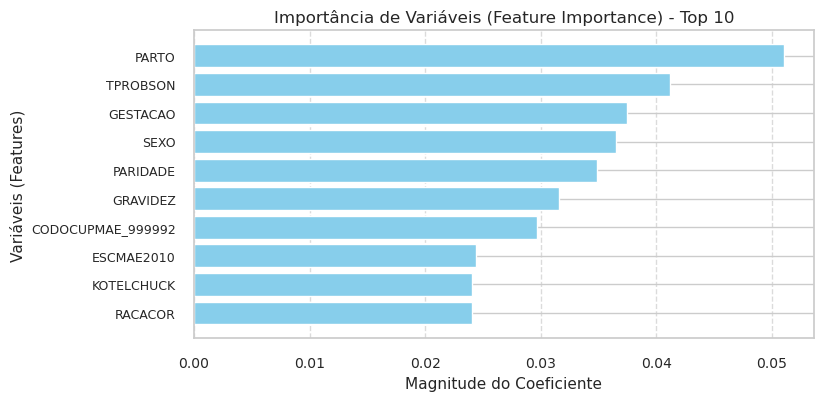

['PARTO' 'TPROBSON' 'GESTACAO' 'SEXO' 'PARIDADE' 'GRAVIDEZ'
 'CODOCUPMAE_999992' 'ESCMAE2010' 'KOTELCHUCK' 'RACACOR']

-------------------------------------------------------------
E2-cV: Validação - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.99      1.00    17654
1             1       0.40    0.61      0.49      132
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.70    0.80      0.74    17786
4  weighted avg       0.99    0.99      0.99    17786
-------------------------------------------------------------
Accuracy: 0.9903856966153154
Confusion Matrix
[[17534   120]
 [   51    81]]


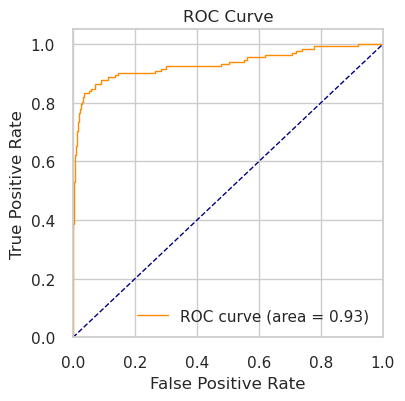

In [32]:
final_report, E2_c = run_experiment('E2-c : Naive Bayes - MultinomialNB',
                              MultinomialNB(),
                                X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)


-------------------------------------------------------------
E2-c : Naive Bayes - MultinomialNB - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.87      0.93    14127
1             1       0.04    0.86      0.08      102
2      accuracy       0.87    0.87      0.87        0
3     macro avg       0.52    0.86      0.51    14229
4  weighted avg       0.99    0.87      0.92    14229
-------------------------------------------------------------


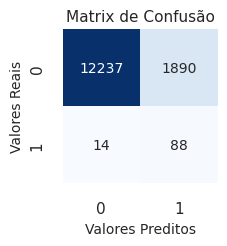

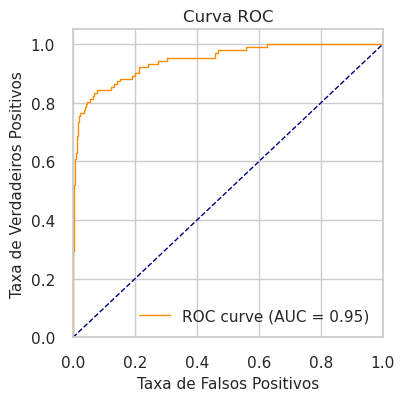

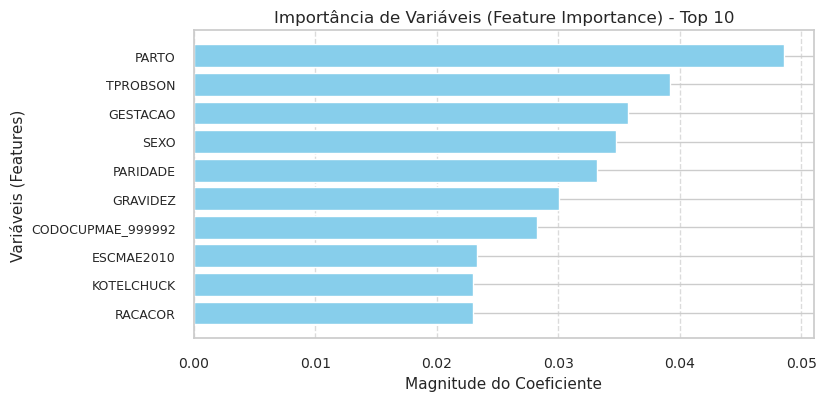

['PARTO' 'TPROBSON' 'GESTACAO' 'SEXO' 'PARIDADE' 'GRAVIDEZ'
 'CODOCUPMAE_999992' 'ESCMAE2010' 'KOTELCHUCK' 'RACACOR']

-------------------------------------------------------------
E2-cV: Validação - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.86      0.93    17654
1             1       0.05    0.89      0.09      132
2      accuracy       0.86    0.86      0.86        0
3     macro avg       0.52    0.87      0.51    17786
4  weighted avg       0.99    0.86      0.92    17786
-------------------------------------------------------------
Accuracy: 0.8635443607331609
Confusion Matrix
[[15242  2412]
 [   15   117]]


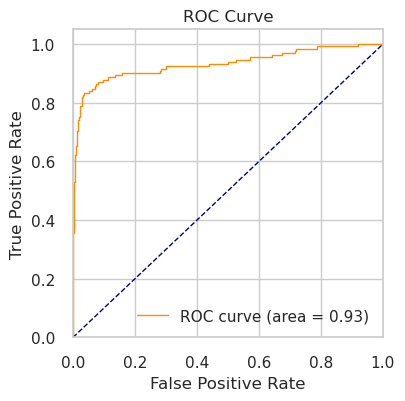

In [33]:
final_report, E2_c = run_experiment('E2-c : Naive Bayes - MultinomialNB',
                              MultinomialNB(class_prior=[0.03,1], alpha=1.4),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)

-------------------------------------------------------------
E2-c : Naive Bayes - MultinomialNB - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.51      0.68    14127
1             1       0.01    0.99      0.03      102
2      accuracy       0.52    0.52      0.52        0
3     macro avg       0.51    0.75      0.35    14229
4  weighted avg       0.99    0.52      0.67    14229
-------------------------------------------------------------


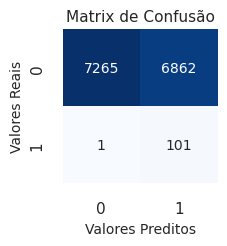

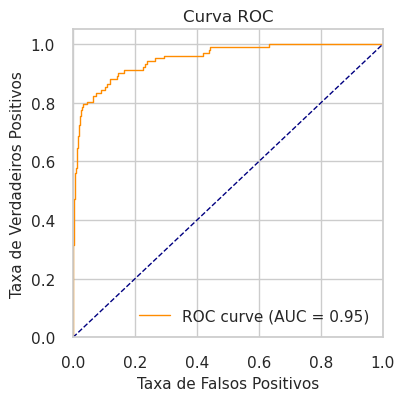

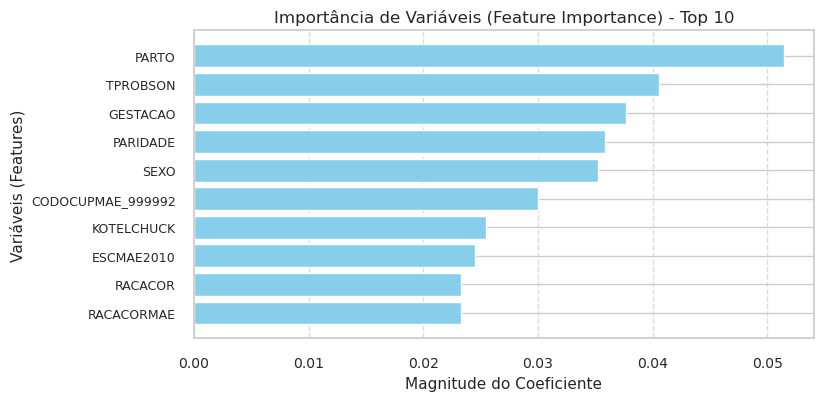

['PARTO' 'TPROBSON' 'GESTACAO' 'PARIDADE' 'SEXO' 'CODOCUPMAE_999992'
 'KOTELCHUCK' 'ESCMAE2010' 'RACACOR' 'RACACORMAE']

-------------------------------------------------------------
E2-cV: Validação - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.39      0.56    17654
1             1       0.01    0.95      0.02      132
2      accuracy       0.39    0.39      0.39        0
3     macro avg       0.51    0.67      0.29    17786
4  weighted avg       0.99    0.39      0.56    17786
-------------------------------------------------------------
Accuracy: 0.39238727088721465
Confusion Matrix
[[ 6853 10801]
 [    6   126]]


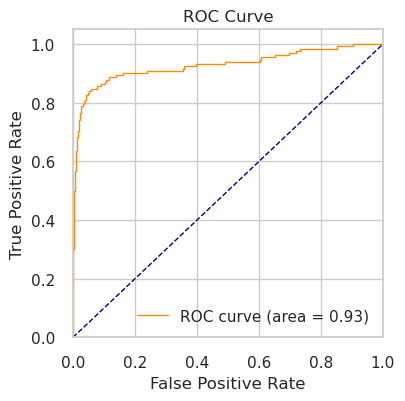

In [34]:
final_report, E2_c = run_experiment('E2-c : Naive Bayes - MultinomialNB',
                              MultinomialNB(class_prior=[0.01,1], alpha=1),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

## E2-d: Modelo Naive Bayes - MultinomialNB - Undersample ENN


-------------------------------------------------------------
E2-d : Naive Bayes - ComplementNB "Undersample" ENN - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.90      0.95    14127
1             1       0.06    0.84      0.11      102
2      accuracy       0.90    0.90      0.90        0
3     macro avg       0.53    0.87      0.53    14229
4  weighted avg       0.99    0.90      0.94    14229
-------------------------------------------------------------


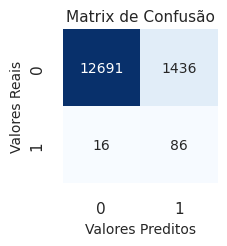

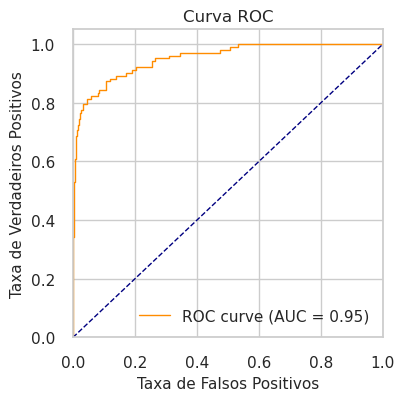

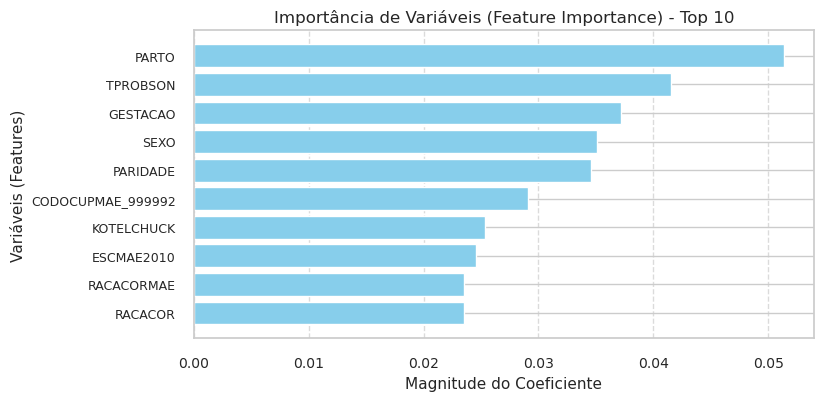

['PARTO' 'TPROBSON' 'GESTACAO' 'SEXO' 'PARIDADE' 'CODOCUPMAE_999992'
 'KOTELCHUCK' 'ESCMAE2010' 'RACACORMAE' 'RACACOR']

-------------------------------------------------------------
E2-dV: Validação - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.90      0.94    17654
1             1       0.06    0.89      0.11      132
2      accuracy       0.90    0.90      0.90        0
3     macro avg       0.53    0.89      0.53    17786
4  weighted avg       0.99    0.90      0.94    17786
-------------------------------------------------------------
Accuracy: 0.8950297987180929
Confusion Matrix
[[15802  1852]
 [   15   117]]


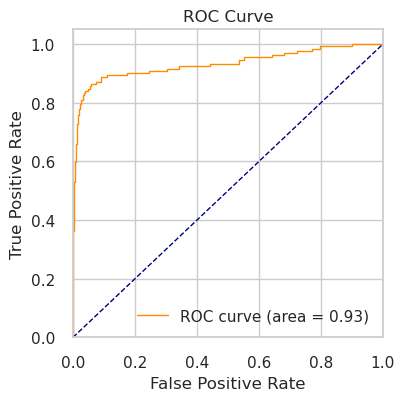

In [35]:
final_report, E2_d = run_experiment('E2-d : Naive Bayes - ComplementNB "Undersample" ENN',
                              MultinomialNB(alpha=1, 
                                            class_prior=[0.2,1]
                                           ),
                              X_train_enn, y_train_enn, X_test, y_test, X_val, y_val,
                              final_report)

## E2-e: Modelo Naive Bayes - MultinomialNB - Oversample


-------------------------------------------------------------
E2-e : Naive Bayes - ComplementNB "Oversample" ADASUYN - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.98      0.99    14127
1             1       0.22    0.67      0.33      102
2      accuracy       0.98    0.98      0.98        0
3     macro avg       0.61    0.82      0.66    14229
4  weighted avg       0.99    0.98      0.99    14229
-------------------------------------------------------------


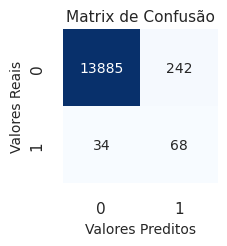

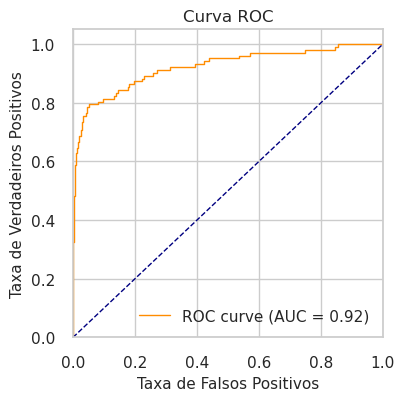

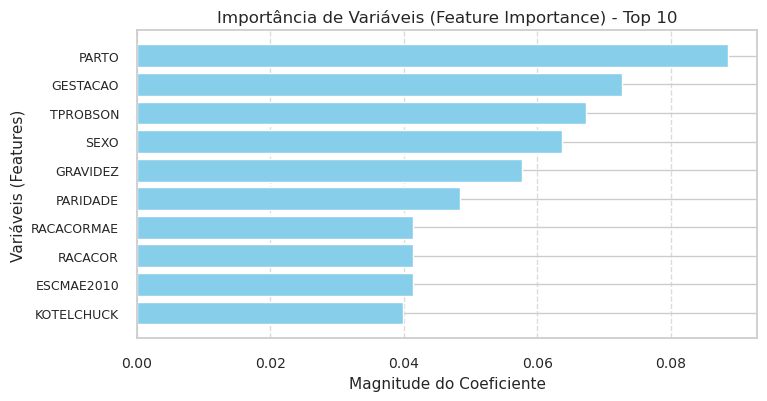

['PARTO' 'GESTACAO' 'TPROBSON' 'SEXO' 'GRAVIDEZ' 'PARIDADE' 'RACACORMAE'
 'RACACOR' 'ESCMAE2010' 'KOTELCHUCK']

-------------------------------------------------------------
E2-eV: Validação - MultinomialNB
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.98      0.99    17654
1             1       0.21    0.66      0.32      132
2      accuracy       0.98    0.98      0.98        0
3     macro avg       0.60    0.82      0.65    17786
4  weighted avg       0.99    0.98      0.98    17786
-------------------------------------------------------------
Accuracy: 0.9789722253457775
Confusion Matrix
[[17325   329]
 [   45    87]]


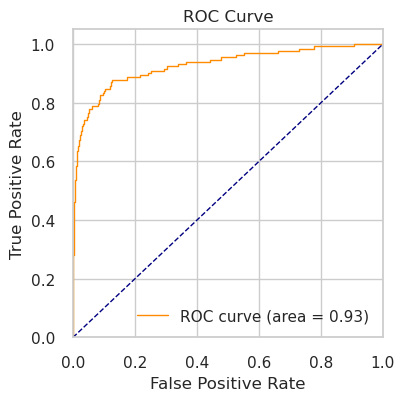

In [36]:
final_report, E2_e = run_experiment('E2-e : Naive Bayes - ComplementNB "Oversample" ADASUYN',
                              MultinomialNB(alpha=9, class_prior=[0.25,1]),
                              X_over, y_over, X_test, y_test, X_val, y_val,
                              final_report)

# E3: Extreme Gradient Boosting

## E3-a : Modelo XGBoost - Baseline

-------------------------------------------------------------
E3-a : XGBoost - Baseline - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       0.99    1.00      1.00    14127
1             1       0.64    0.28      0.39      102
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.82    0.64      0.70    14229
4  weighted avg       0.99    0.99      0.99    14229
-------------------------------------------------------------


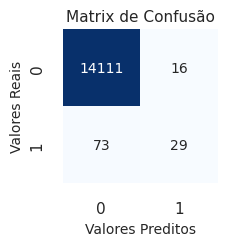

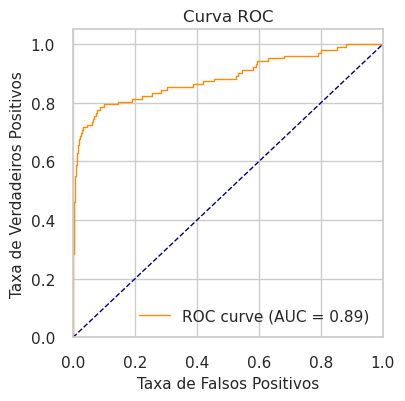

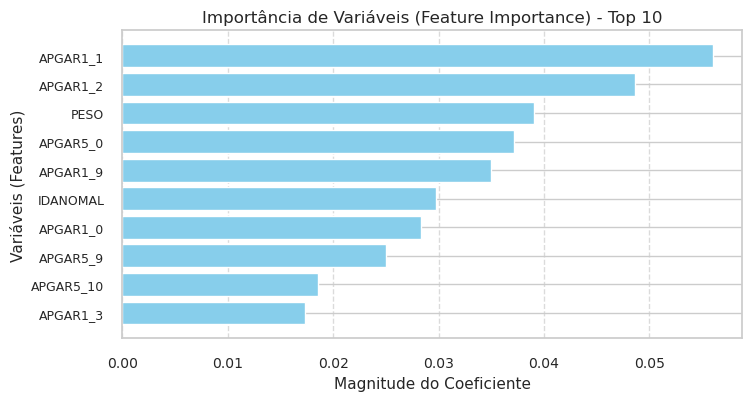

['APGAR1_1' 'APGAR1_2' 'PESO' 'APGAR5_0' 'APGAR1_9' 'IDANOMAL' 'APGAR1_0'
 'APGAR5_9' 'APGAR5_10' 'APGAR1_3']



100%|===================| 14197/14229 [00:30<00:00]        

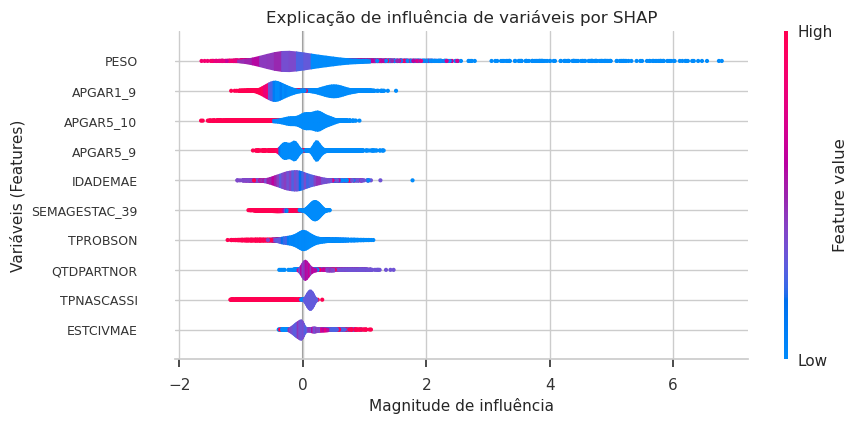

-------------------------------------------------------------
E3-aV: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    1.00      1.00    17654
1             1       0.73    0.35      0.47      132
2      accuracy       0.99    0.99      0.99        0
3     macro avg       0.86    0.67      0.73    17786
4  weighted avg       0.99    0.99      0.99    17786
-------------------------------------------------------------
Accuracy: 0.9942089283706286
Confusion Matrix
[[17637    17]
 [   86    46]]


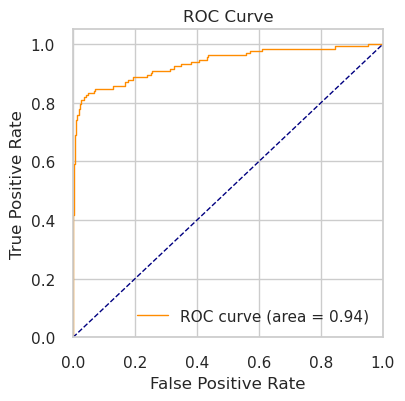

In [37]:
final_report, E3_a = run_experiment('E3-a : XGBoost - Baseline',
                              xgb.XGBClassifier(random_state=42),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)

## E3-b : Modelo XGBoost - Balancemanto Undersample aleatório

#### Simple Plan

-------------------------------------------------------------
E3-b : XGBoost - Balanceamento "Undersample" - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.92      0.96    14127
1             1       0.08    0.94      0.14      102
2      accuracy       0.92    0.92      0.92        0
3     macro avg       0.54    0.93      0.55    14229
4  weighted avg       0.99    0.92      0.95    14229
-------------------------------------------------------------


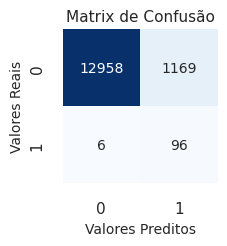

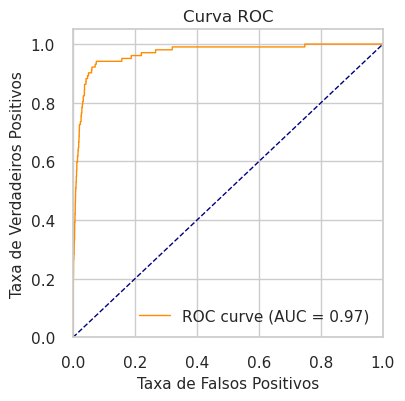

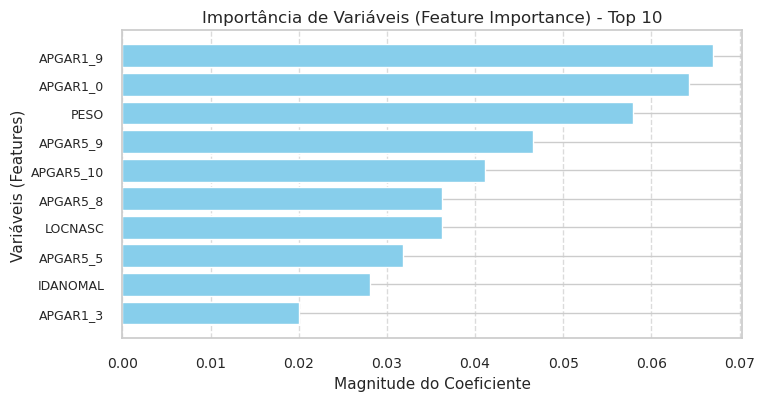

['APGAR1_9' 'APGAR1_0' 'PESO' 'APGAR5_9' 'APGAR5_10' 'APGAR5_8' 'LOCNASC'
 'APGAR5_5' 'IDANOMAL' 'APGAR1_3']



 99%|===================| 14031/14229 [00:42<00:00]        

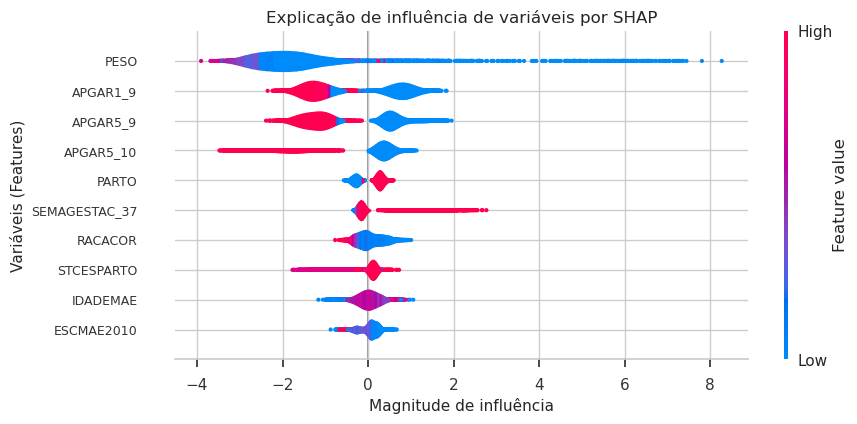

-------------------------------------------------------------
E3-bV: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.89      0.94    17654
1             1       0.06    0.88      0.10      132
2      accuracy       0.89    0.89      0.89        0
3     macro avg       0.53    0.88      0.52    17786
4  weighted avg       0.99    0.89      0.93    17786
-------------------------------------------------------------
Accuracy: 0.8871022152254582
Confusion Matrix
[[15662  1992]
 [   16   116]]


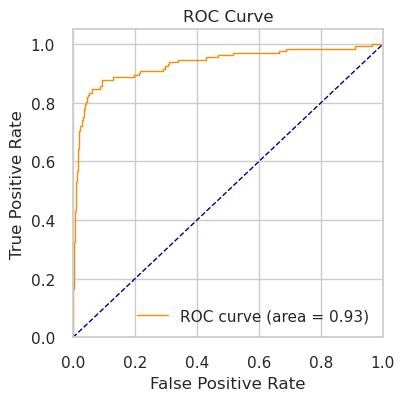

In [38]:
final_report, E3_b = run_experiment('E3-b : XGBoost - Balanceamento "Undersample"',
                              xgb.XGBClassifier(random_state=42),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

#### Model

-------------------------------------------------------------
E3-b : XGBoost - Balanceamento "Undersample" - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.86      0.92    14127
1             1       0.04    0.91      0.08      102
2      accuracy       0.86    0.86      0.86        0
3     macro avg       0.52    0.88      0.50    14229
4  weighted avg       0.99    0.86      0.92    14229
-------------------------------------------------------------


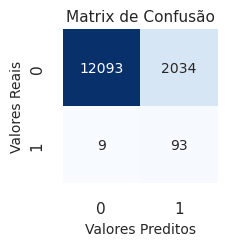

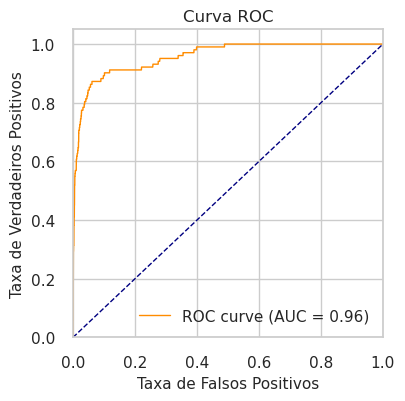

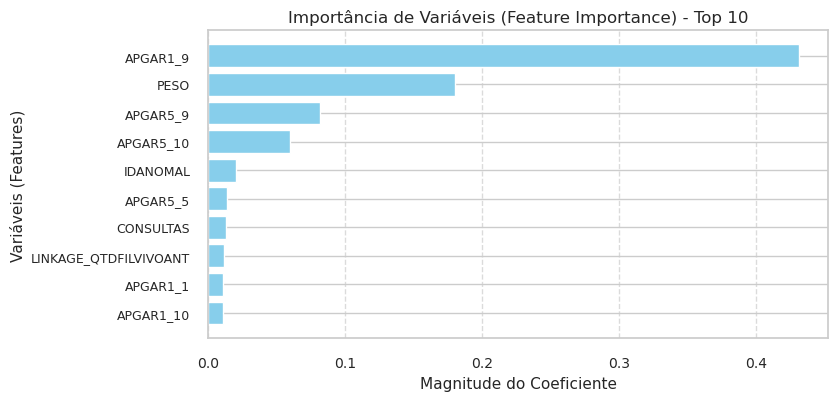

['APGAR1_9' 'PESO' 'APGAR5_9' 'APGAR5_10' 'IDANOMAL' 'APGAR5_5'
 'CONSULTAS' 'LINKAGE_QTDFILVIVOANT' 'APGAR1_1' 'APGAR1_10']



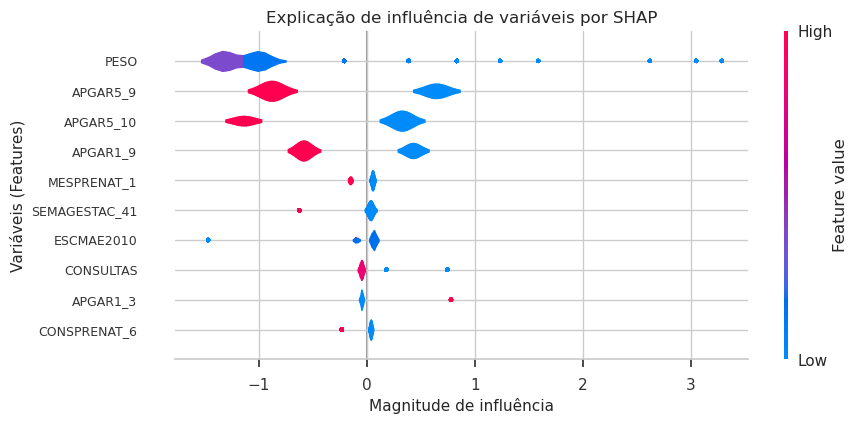

-------------------------------------------------------------
E3-bV: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.78      0.88    17654
1             1       0.03    0.93      0.06      132
2      accuracy       0.78    0.78      0.78        0
3     macro avg       0.52    0.86      0.47    17786
4  weighted avg       0.99    0.78      0.87    17786
-------------------------------------------------------------
Accuracy: 0.7835938378499944
Confusion Matrix
[[13814  3840]
 [    9   123]]


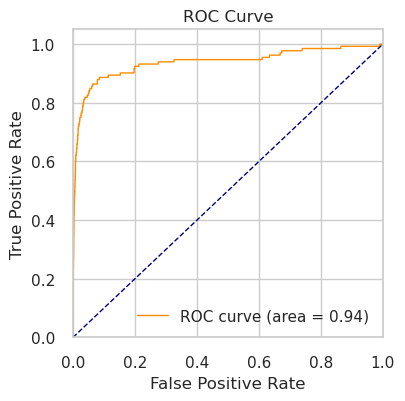

In [39]:
final_report, E3_b = run_experiment('E3-b : XGBoost - Balanceamento "Undersample"',
                              xgb.XGBClassifier(random_state=42,
                                                scale_pos_weight=3,
                                                max_depth=1,
                                                #learning_rate=0.04,
                                                #objective='binary:logistic', eval_metric='error'
                                               ),
                              X_train_bal, y_train_bal, X_test, y_test, X_val, y_val,
                              final_report)

## E3-c : Modelo XGBoost - Balancemanto Undersample ENN



In [ ]:
final_report, E3_c = run_experiment('E3-c : XGBoost - Balanceamento "Undersample" ENN',
                              xgb.XGBClassifier(random_state=42),
                              X_train_enn, y_train_enn, X_test, y_test, X_val, y_val,
                              final_report)

In [ ]:
final_report, E3_c = run_experiment('E3-c : XGBoost - Balanceamento "Undersample" ENN',
                              xgb.XGBClassifier(random_state=42,
                                                #objective='binary:logistic',
                                                #eval_metric='error',
                                                scale_pos_weight=10,
                                                max_depth=2,
                                                #learning_rate=0.04
                                               ),
                              X_train_enn, y_train_enn, X_test, y_test, X_val, y_val,
                              final_report)


## E3-d : Modelo XGBoost - Peso paramétrico

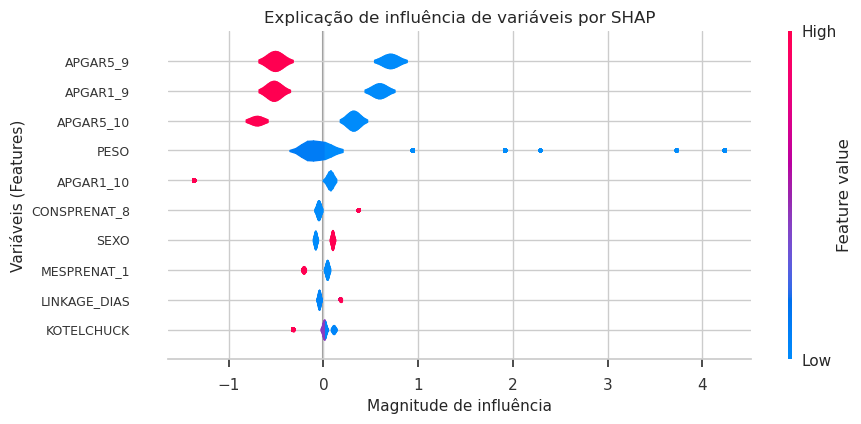

-------------------------------------------------------------
E3-dV: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.89      0.94    17654
1             1       0.06    0.90      0.11      132
2      accuracy       0.89    0.89      0.89        0
3     macro avg       0.53    0.89      0.52    17786
4  weighted avg       0.99    0.89      0.93    17786
-------------------------------------------------------------
Accuracy: 0.8868210952434499
Confusion Matrix
[[15654  2000]
 [   13   119]]


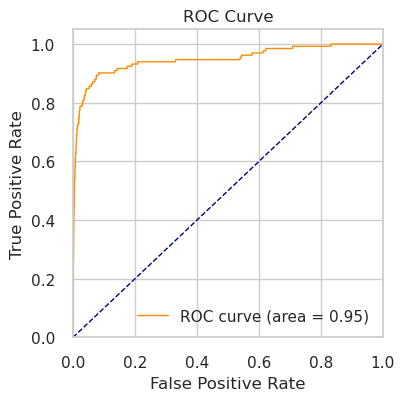

In [42]:
final_report, E3_d = run_experiment('E3-d : XGBoost - Peso paramétrico',
                              xgb.XGBClassifier(random_state=42,
                                                #objective='binary:logistic',
                                                #eval_metric='error',
                                                scale_pos_weight=400,
                                                max_depth=1,
                                                #learning_rate=0.25
                                               ),
                              X_train, y_train, X_test, y_test, X_val, y_val,
                              final_report)

## E3-e : Modelo XGBoost - Oversample

-------------------------------------------------------------
E3-e : XGBoost - Balanceamento "Oversample" ADASUYN - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.90      0.95    14127
1             1       0.06    0.87      0.11      102
2      accuracy       0.90    0.90      0.90        0
3     macro avg       0.53    0.89      0.53    14229
4  weighted avg       0.99    0.90      0.94    14229
-------------------------------------------------------------


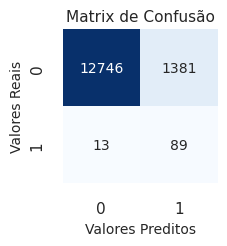

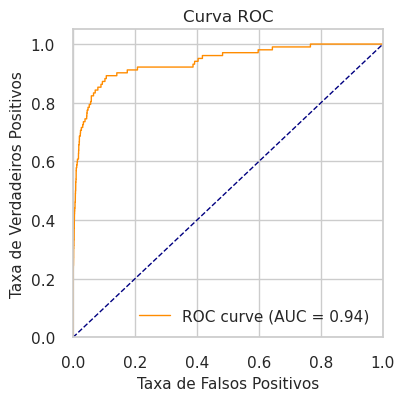

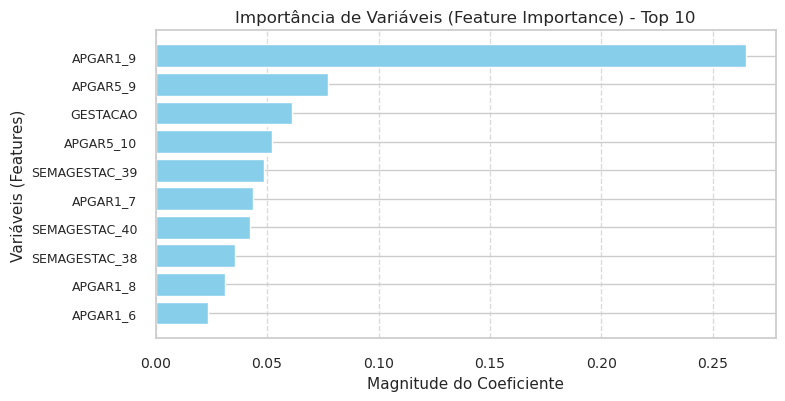

['APGAR1_9' 'APGAR5_9' 'GESTACAO' 'APGAR5_10' 'SEMAGESTAC_39' 'APGAR1_7'
 'SEMAGESTAC_40' 'SEMAGESTAC_38' 'APGAR1_8' 'APGAR1_6']



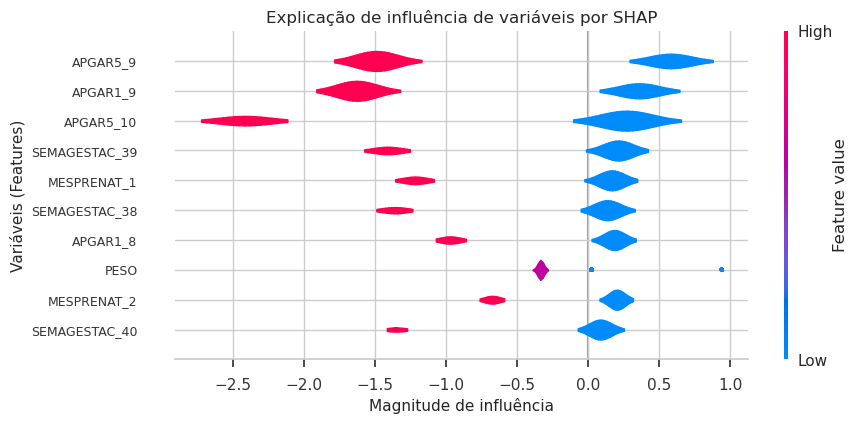

-------------------------------------------------------------
E3-eV: Validação - XGBClassifier
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.89      0.94    17654
1             1       0.06    0.87      0.11      132
2      accuracy       0.89    0.89      0.89        0
3     macro avg       0.53    0.88      0.52    17786
4  weighted avg       0.99    0.89      0.94    17786
-------------------------------------------------------------
Accuracy: 0.8920499269088047
Confusion Matrix
[[15751  1903]
 [   17   115]]


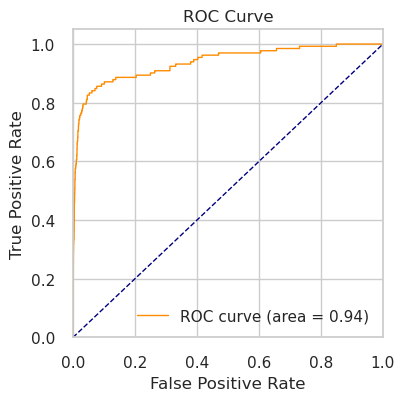

In [43]:
final_report, E3_e = run_experiment('E3-e : XGBoost - Balanceamento "Oversample" ADASUYN',
                              xgb.XGBClassifier(objective='binary:logistic',
                                                eval_metric='error',
                                                scale_pos_weight=30,
                                                max_depth=1,
                                                #learning_rate=0.25
                                                ),
                              X_over, y_over, X_test, y_test, X_val, y_val,
                              final_report)

# E4: Abordagem "One Class"

https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00514-x


## E4-a : One Class SVM

In [44]:
'''
final_report, E4_a = run_experiment('E4-a : One Class SVM - rbf',
                              OneClassSVM(nu=0.45, 
                                          kernel="linear", 
                                          gamma='auto'),
                              X_train_class0, np.zeros(len(X_train_class0), dtype=int), 
                                    X_test_both, y_test_both, X_val, y_val,
                              final_report)
'''

'\nfinal_report, E4_a = run_experiment(\'E4-a : One Class SVM - rbf\',\n                              OneClassSVM(nu=0.45, \n                                          kernel="linear", \n                                          gamma=\'auto\'),\n                              X_train_class0, np.zeros(len(X_train_class0), dtype=int), \n                                    X_test_both, y_test_both, X_val, y_val,\n                              final_report)\n'

## E4-b : One Class SVM - SGD

-------------------------------------------------------------
E4-b : One Class SVM - SGD  - SGDOneClassSVM
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.74      0.85    14127
1             1       0.02    0.78      0.04      102
2      accuracy       0.74    0.74      0.74        0
3     macro avg       0.51    0.76      0.45    14229
4  weighted avg       0.99    0.74      0.85    14229
-------------------------------------------------------------


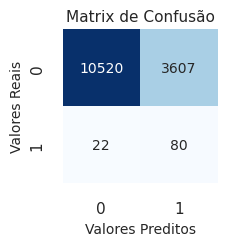

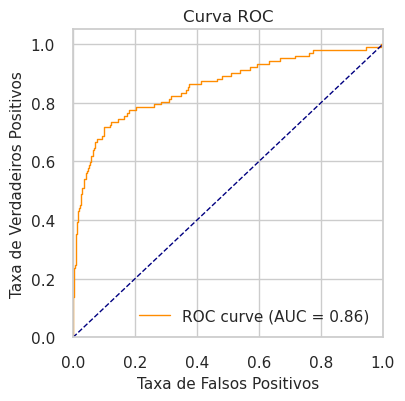

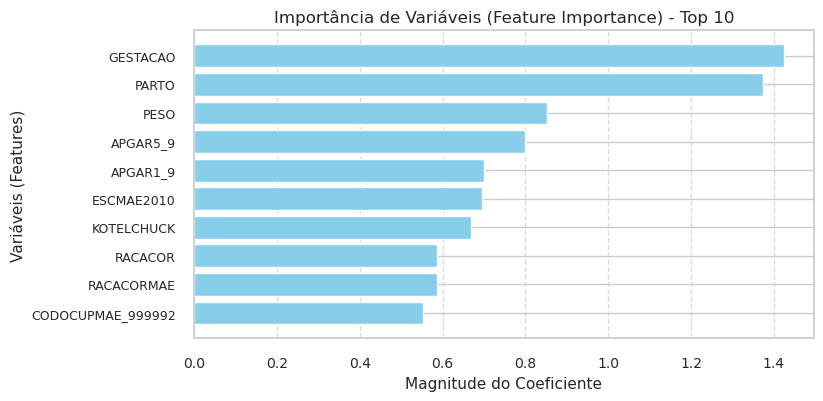

['GESTACAO' 'PARTO' 'PESO' 'APGAR5_9' 'APGAR1_9' 'ESCMAE2010' 'KOTELCHUCK'
 'RACACOR' 'RACACORMAE' 'CODOCUPMAE_999992']

-------------------------------------------------------------
E4-bV: Validação - SGDOneClassSVM
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.75      0.85    17654
1             1       0.02    0.83      0.05      132
2      accuracy       0.75    0.75      0.75        0
3     macro avg       0.51    0.79      0.45    17786
4  weighted avg       0.99    0.75      0.85    17786
-------------------------------------------------------------
Accuracy: 0.7477229281457326
Confusion Matrix
[[13189  4465]
 [   22   110]]


In [45]:
# SGDOneClassSVM estimator has a linear complexity in the number of training samples and is
#thus better suited than the sklearn.svm.OneClassSVM implementation for datasets
# with a large number of training samples (say > 10,000).

final_report, E4_b = run_experiment('E4-b : One Class SVM - SGD ',
                              SGDOneClassSVM(nu=0.33, random_state=42),
                              X_train_class0, np.zeros(len(X_test_class0), dtype=int), X_test, y_test, X_val, y_val,
                              final_report)


## E4-c : One Class - Isolation Forest

-------------------------------------------------------------
E4-c : One Class - Isolation Forest - IsolationForest
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.87      0.93    14127
1             1       0.03    0.48      0.05      102
2      accuracy       0.87    0.87      0.87        0
3     macro avg       0.51    0.68      0.49    14229
4  weighted avg       0.99    0.87      0.92    14229
-------------------------------------------------------------


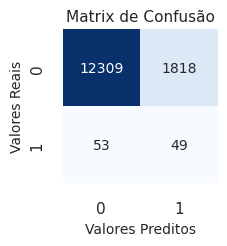

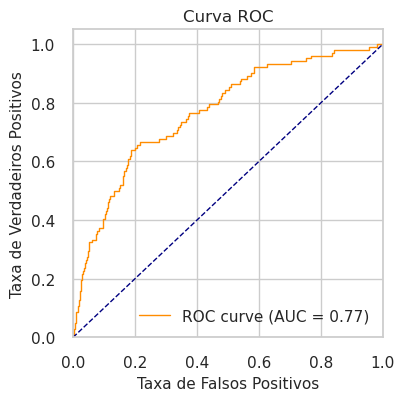

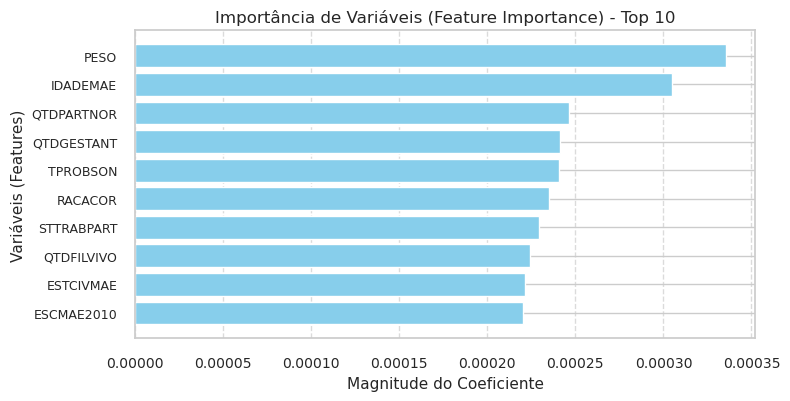

['PESO' 'IDADEMAE' 'QTDPARTNOR' 'QTDGESTANT' 'TPROBSON' 'RACACOR'
 'STTRABPART' 'QTDFILVIVO' 'ESTCIVMAE' 'ESCMAE2010']

-------------------------------------------------------------
E4-cV: Validação - IsolationForest
-------------------------------------------------------------
Relatório de Classificação:
          index  precision  recall  f1-score  support
0             0       1.00    0.90      0.95    17654
1             1       0.04    0.51      0.07      132
2      accuracy       0.90    0.90      0.90        0
3     macro avg       0.52    0.71      0.51    17786
4  weighted avg       0.99    0.90      0.94    17786
-------------------------------------------------------------
Accuracy: 0.9011019903294726
Confusion Matrix
[[15960  1694]
 [   65    67]]


In [46]:
final_report, E4_c = run_experiment('E4-c : One Class - Isolation Forest',
                              IsolationForest(random_state=42, contamination=0.042, max_features=X_train_class0.shape[1]),
                              X_train_class0, np.zeros(len(X_test_class0), dtype=int), X_test, y_test, X_val, y_val,
                              final_report)

# E5 - Ensamble

### def ensamble_metric

In [47]:
def ensamble_metric(models, model_names, colors, X_, y_):

    predict_array = []
    proba_array = []
    
    plt.figure(figsize=(7, 7))
    
    for model, name, color in zip(models, model_names, colors):
        pred = model.predict(X_)

        if type(model).__name__ in ['IsolationForest','SGDOneClassSVM', 'OneClassSVM']:
            # Calculate Proba
            outlier_scores = model.decision_function(X_)
            
            # Normalize the scores to the range [0, 1]
            normalized_scores = (outlier_scores - min(outlier_scores)) / (max(outlier_scores) - min(outlier_scores))
            
            # Invert the scores
            inverted_scores = 1 - normalized_scores
            
            # Create probability arrays
            probas = np.zeros((len(X_), 2))
            probas[:, 0] = inverted_scores
            probas[:, 1] = 1 - inverted_scores
            probas = probas#[:, 0]
        else:
            probas = model.predict_proba(X_)
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_, probas[:, 1])
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, color=color, lw=1, label='%s (AUC = %0.2f)' % (name, roc_auc))
        
        predict_array.append(pred)
        proba_array.append(probas)

    # Assuming proba_arrays contains probabilities from each model
    ensemble_probs = np.mean(proba_array, axis=0)
    
    # Make final predictions
    ensemble_preds_proab = np.argmax(ensemble_probs, axis=1)
        
    # Evaluate ensemble accuracy
    ensemble_accuracy = accuracy_score(y_, ensemble_preds_proab)
    print("Ensemble Accuracy:", ensemble_accuracy)
    
    cm = confusion_matrix(y_, ensemble_preds_proab)
    print(cm)
    
    # Calculate classification report for probability averaging ensemble
    ensemble_classification_report_proba = classification_report(y_, ensemble_preds_proab)
    print("Classification Report for Probability Averaging Ensemble:\n", ensemble_classification_report_proba)
    
    # Compute ROC curve
    # Assuming y_val contains binary labels (0 and 1) and ensemble_probs contains predicted probabilities for class 1
    fpr, tpr, thresholds = roc_curve(y_, ensemble_probs[:, 1]) 
    
    # Compute ROC area under the curve (AUC)
    roc_auc = roc_auc_score(y_, ensemble_probs[:, 1])
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='orange', lw=2, label='Averaging Ensemble (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


### Logistic Regression

Ensemble Accuracy: 0.923044486611849
[[13047  1080]
 [   15    87]]
Classification Report for Probability Averaging Ensemble:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     14127
           1       0.07      0.85      0.14       102

    accuracy                           0.92     14229
   macro avg       0.54      0.89      0.55     14229
weighted avg       0.99      0.92      0.95     14229



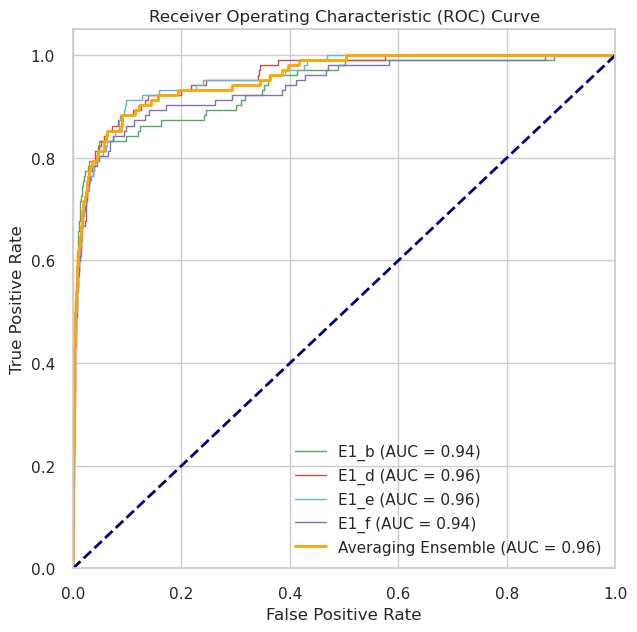

Ensemble Accuracy: 0.9071741819408523
[[16021  1633]
 [   18   114]]
Classification Report for Probability Averaging Ensemble:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     17654
           1       0.07      0.86      0.12       132

    accuracy                           0.91     17786
   macro avg       0.53      0.89      0.54     17786
weighted avg       0.99      0.91      0.94     17786



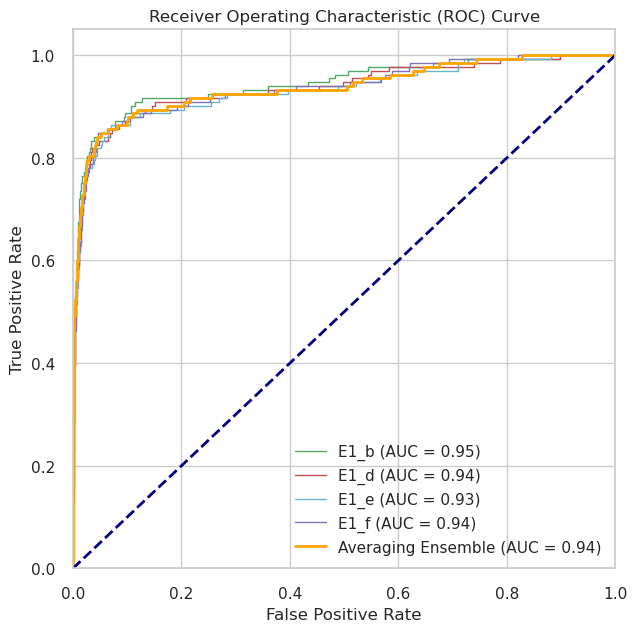

In [48]:
# Logistic
models = [E1_a, 
          E1_b, 
          E1_d,
          E1_e,
          E1_f
         ]

model_names = ['E1_b', 'E1_d', 'E1_e', 'E1_f']
colors = ['g', 'r', 'c', 'm']
ensamble_metric(models, model_names, colors, X_test, y_test)
ensamble_metric(models, model_names, colors, X_val, y_val)


### Naive Bayes

Ensemble Accuracy: 0.9117295663785228
[[12887  1240]
 [   16    86]]
Classification Report for Probability Averaging Ensemble:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     14127
           1       0.06      0.84      0.12       102

    accuracy                           0.91     14229
   macro avg       0.53      0.88      0.54     14229
weighted avg       0.99      0.91      0.95     14229



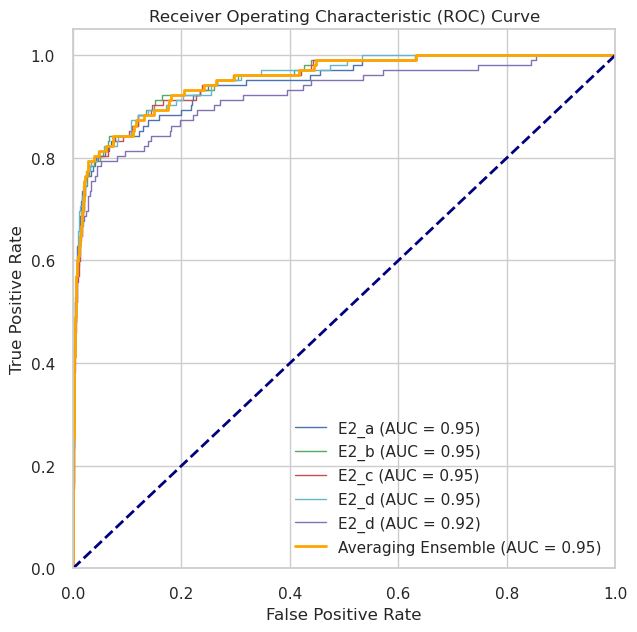

Ensemble Accuracy: 0.9032385021927358
[[15950  1704]
 [   17   115]]
Classification Report for Probability Averaging Ensemble:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     17654
           1       0.06      0.87      0.12       132

    accuracy                           0.90     17786
   macro avg       0.53      0.89      0.53     17786
weighted avg       0.99      0.90      0.94     17786



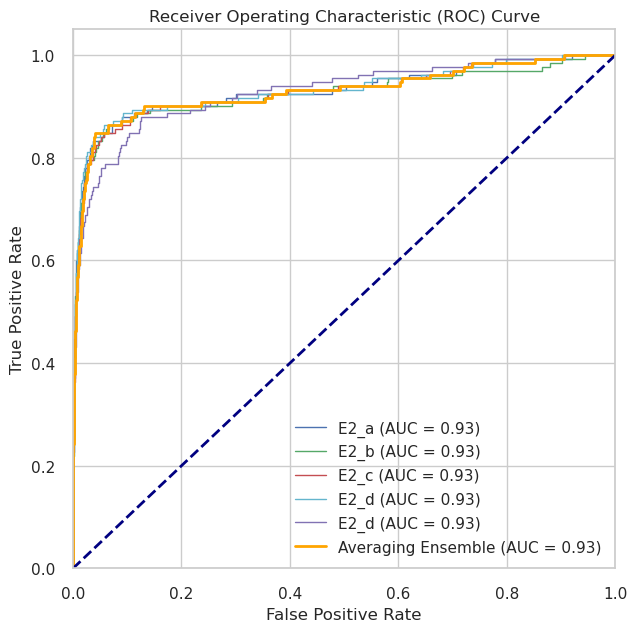

In [49]:
# Naive
models = [E2_a, 
          E2_b, 
          E2_c,
          E2_d,
          E2_e
         ]

model_names = ['E2_a', 'E2_b', 'E2_c', 'E2_d', 'E2_d']
colors = ['b', 'g', 'r', 'c', 'm']
ensamble_metric(models, model_names, colors, X_test, y_test)
ensamble_metric(models, model_names, colors, X_val, y_val)


### XGBoost

Ensemble Accuracy: 0.9475015812776724
[[13398   729]
 [   18    84]]
Classification Report for Probability Averaging Ensemble:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     14127
           1       0.10      0.82      0.18       102

    accuracy                           0.95     14229
   macro avg       0.55      0.89      0.58     14229
weighted avg       0.99      0.95      0.97     14229



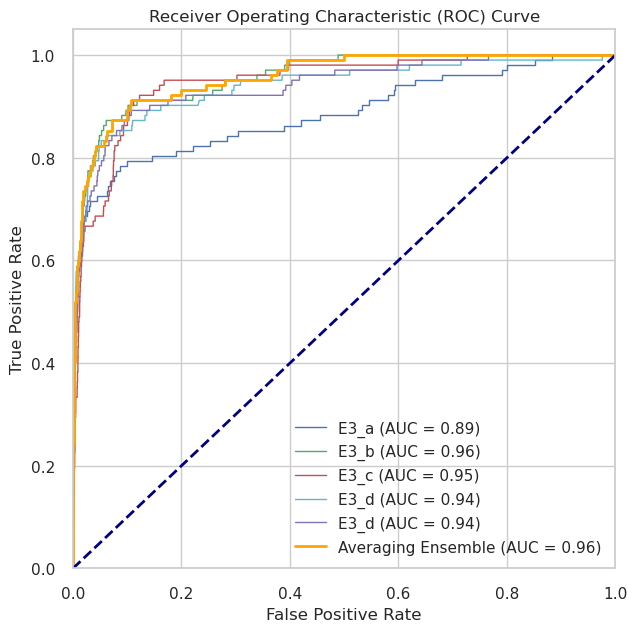

Ensemble Accuracy: 0.9292702125267064
[[16415  1239]
 [   19   113]]
Classification Report for Probability Averaging Ensemble:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     17654
           1       0.08      0.86      0.15       132

    accuracy                           0.93     17786
   macro avg       0.54      0.89      0.56     17786
weighted avg       0.99      0.93      0.96     17786



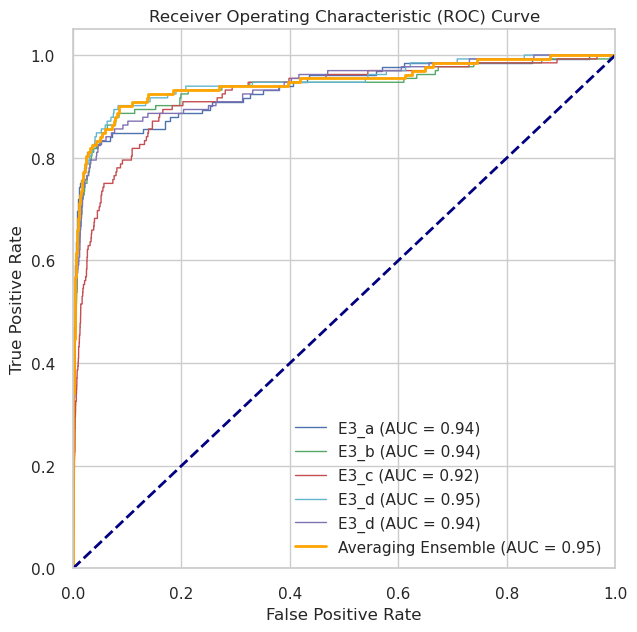

In [50]:
# XGBoost
models = [E3_a, 
          E3_b, 
          E3_c,
          E3_d,
          E3_e
         ]

model_names = ['E3_a', 'E3_b', 'E3_c', 'E3_d', 'E3_d']
colors = ['b', 'g', 'r', 'c', 'm']
ensamble_metric(models, model_names, colors, X_test, y_test)
ensamble_metric(models, model_names, colors, X_val, y_val)


### Best ensambles

Ensemble Accuracy: 0.917914119052639
[[12974  1153]
 [   15    87]]
Classification Report for Probability Averaging Ensemble:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     14127
           1       0.07      0.85      0.13       102

    accuracy                           0.92     14229
   macro avg       0.53      0.89      0.54     14229
weighted avg       0.99      0.92      0.95     14229



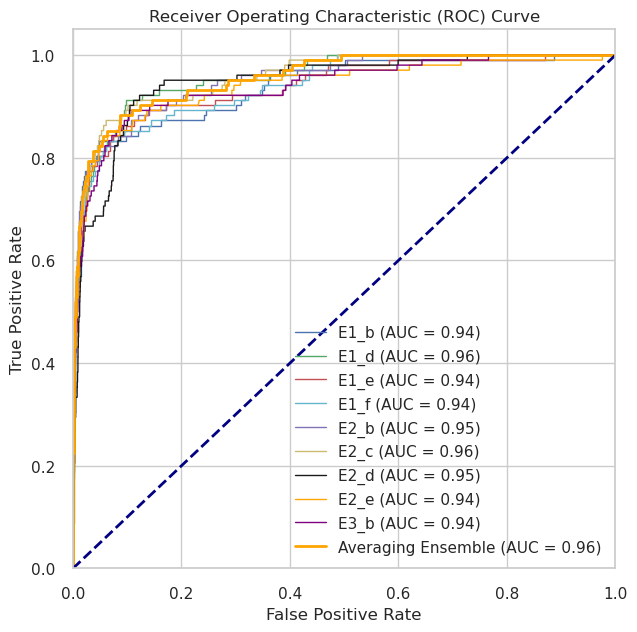

Ensemble Accuracy: 0.9034071741819408
[[15949  1705]
 [   13   119]]
Classification Report for Probability Averaging Ensemble:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     17654
           1       0.07      0.90      0.12       132

    accuracy                           0.90     17786
   macro avg       0.53      0.90      0.54     17786
weighted avg       0.99      0.90      0.94     17786



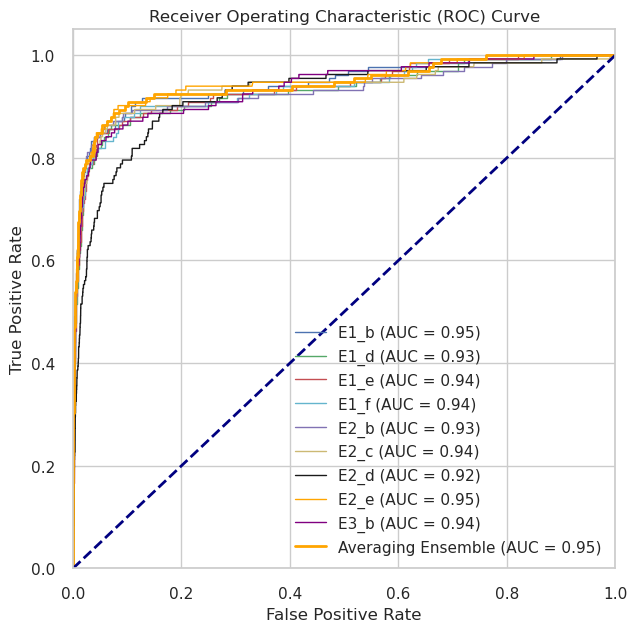

In [51]:
models = [E1_a, E1_d, E1_e, E1_f, E2_d, E3_b, E3_c, E3_d, E3_e ]
model_names = ['E1_b', 'E1_d', 'E1_e', 'E1_f', 'E2_b', 'E2_c', 'E2_d', 'E2_e', 'E3_b', 'E3_c', 'E3_d', 'E3_e', 'E4_b', 'E4_c']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']


ensamble_metric(models, model_names, colors, X_test, y_test)
ensamble_metric(models, model_names, colors, X_val, y_val)


### Ensamble

Ensemble Accuracy: 0.92662871600253
[[13098  1029]
 [   15    87]]
Classification Report for Probability Averaging Ensemble:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     14127
           1       0.08      0.85      0.14       102

    accuracy                           0.93     14229
   macro avg       0.54      0.89      0.55     14229
weighted avg       0.99      0.93      0.96     14229



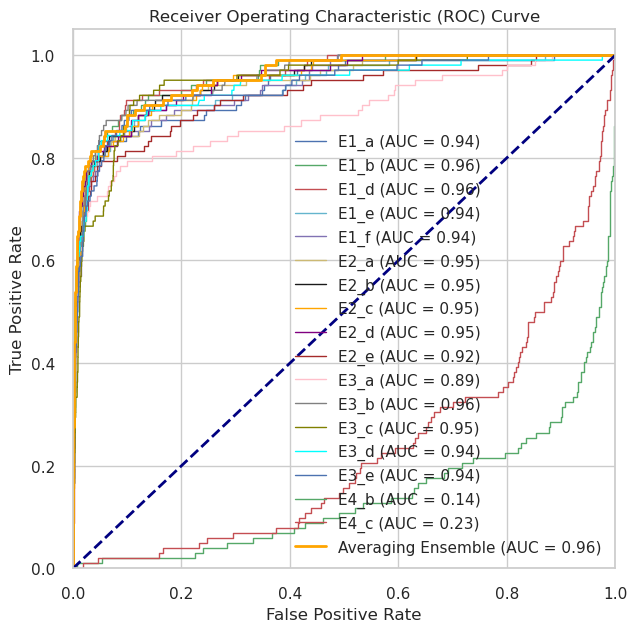

Ensemble Accuracy: 0.9143708534802654
[[16146  1508]
 [   15   117]]
Classification Report for Probability Averaging Ensemble:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     17654
           1       0.07      0.89      0.13       132

    accuracy                           0.91     17786
   macro avg       0.54      0.90      0.54     17786
weighted avg       0.99      0.91      0.95     17786



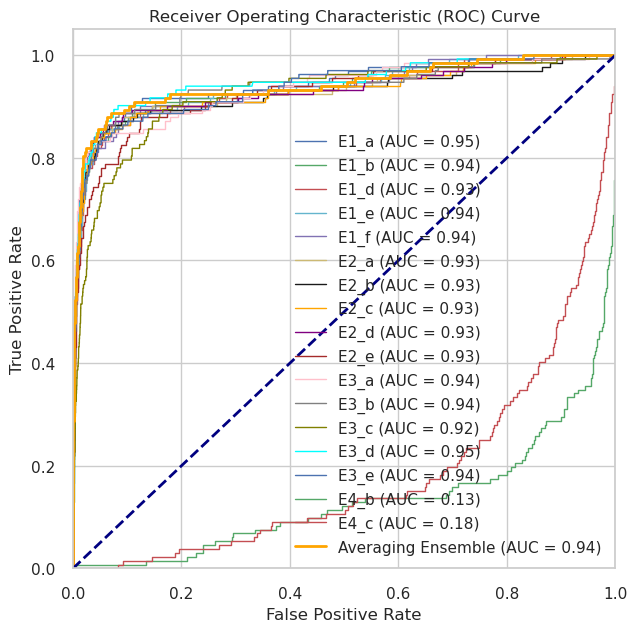

In [52]:
models = [E1_a, E1_b, E1_d, E1_e, E1_f, E2_a, E2_b, E2_c, E2_d, E2_e, E3_a, E3_b, E3_c, E3_d, E3_e, E4_b, E4_c]
model_names = ['E1_a', 'E1_b', 'E1_d', 'E1_e', 'E1_f', 'E2_a', 'E2_b', 'E2_c', 'E2_d', 'E2_e', 'E3_a', 'E3_b', 'E3_c', 'E3_d', 'E3_e', 'E4_b', 'E4_c']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'b', 'g', 'r', 'c']


ensamble_metric(models, model_names, colors, X_test, y_test)
ensamble_metric(models, model_names, colors, X_val, y_val)


# CHECKPOINT 2 -> Outras Análises

## Metricas

## Métricas

In [53]:
final_report.to_csv(folder + 'final_report.csv', index=False)
final_report[final_report['index'] == '1'].sort_values(by='f1-score', ascending=False)

# index  precision  recall  f1-score  support  \
106  E2-cV     1       0.40    0.61      0.49      132   
156  E3-aV     1       0.73    0.35      0.47      132   
101  E2-c      1       0.40    0.56      0.46      102   
6    E1-aV     1       0.62    0.34      0.44      132   
91   E2-b      1       0.34    0.61      0.43      102   
96   E2-bV     1       0.31    0.58      0.40      132   
151  E3-a      1       0.64    0.28      0.39      102   
1    E1-a      1       0.60    0.28      0.39      102   
141  E2-e      1       0.22    0.67      0.33      102   
146  E2-eV     1       0.21    0.66      0.32      132   
31   E1-d      1       0.15    0.88      0.25      102   
66   E2-aV     1       0.12    0.83      0.21      132   
61   E2-a      1       0.11    0.80      0.19      102   
76   E2-bV     1       0.10    0.85      0.17      132   
71   E2-b      1       0.09    0.81      0.16      102   
11   E1-b      1       0.08    0.86      0.15      102   
181  E3-c      1       0.08    0.82      0.14      102   
161  E3-b      1       0.08    0.94      0.14      102   
191  E3-c      1       0.07    0.82      0.13      102   
16   E1-bV     1       0.06    0.89      0.12      132   
131  E2-d      1       0.06    0.84      0.11      102   
206  E3-dV     1       0.06    0.90      0.11      132   
216  E3-eV     1       0.06    0.87      0.11      132   
211  E3-e      1       0.06    0.87      0.11      102   
136  E2-dV     1       0.06    0.89      0.11      132   
166  E3-bV     1       0.06    0.88      0.10      132   
81   E2-b      1       0.05    0.85      0.10      102   
201  E3-d      1       0.05    0.87      0.09      102   
41   E1-e      1       0.05    0.87      0.09      102   
21   E1-b      1       0.05    0.89      0.09      102   
116  E2-cV     1       0.05    0.89      0.09      132   
46   E1-eV     1       0.04    0.89      0.08      132   
111  E2-c      1       0.04    0.86      0.08      102   
26   E1-bV     1       0.04    0.91      0.08      132   
196  E3-cV     1       0.04    0.88      0.08      132   
171  E3-b      1       0.04    0.91      0.08      102   
86   E2-bV     1       0.04    0.89      0.08      132   
51   E1-f:     1       0.04    0.87      0.08      102   
186  E3-cV     1       0.04    0.83      0.08      132   
236  E4-cV     1       0.04    0.51      0.07      132   
56   E1-fV     1       0.04    0.90      0.07      132   
176  E3-bV     1       0.03    0.93      0.06      132   
36   E1-dV     1       0.03    0.90      0.06      132   
226  E4-bV     1       0.02    0.83      0.05      132   
231  E4-c      1       0.03    0.48      0.05      102   
221  E4-b      1       0.02    0.78      0.04      102   
121  E2-c      1       0.01    0.99      0.03      102   
126  E2-cV     1       0.01    0.95      0.02      132   

                                             Descrição  
106                                   E2-cV: Validação  
156                                   E3-aV: Validação  
101                 E2-c : Naive Bayes - MultinomialNB  
6                                     E1-aV: Validação  
91     E2-b : Naive Bayes - ComplementNB - Ajuste Fino  
96                                    E2-bV: Validação  
151                          E3-a : XGBoost - Baseline  
1                E1-a : Regressão Logística - Baseline  
141  E2-e : Naive Bayes - ComplementNB "Oversample"...  
146                                   E2-eV: Validação  
31   E1-d : Regressão Logística - Balanceamento "Un...  
66                                    E2-aV: Validação  
61                   E2-a : Naive Bayes - ComplementNB  
76                                    E2-bV: Validação  
71     E2-b : Naive Bayes - ComplementNB - Ajuste Fino  
11   E1-b : Regressão Logística - Balanceamento "Un...  
181   E3-c : XGBoost - Balanceamento "Undersample" ENN  
161       E3-b : XGBoost - Balanceamento "Undersample"  
191   E3-c : XGBoost - Balanceamento "Undersample" ENN  
16                        

### E6: Análise de Precison/Recall


In [54]:
# Get predicted probabilities on the test set
y_scores = ensemble_probs[:, 1]#E3_a.predict_proba(X_val)[:, 1]

# Use the true labels for the test set
y_true = y_

# Compute Precision-Recall curve values
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Plot Precision-Recall curve with threshold on x-axis
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Precision', color=color)
ax1.plot(thresholds, precision[:-1], color=color, marker='.', label='Precision')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 1])

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Recall', color=color)
ax2.plot(thresholds, recall[:-1], color=color, marker='.', label='Recall')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1])

fig.tight_layout()
plt.title('Precision-Recall Curve with Threshold on X-axis')
plt.show()

NameError: name 'ensemble_probs' is not defined

In [ ]:

# Assuming you have probability estimates for the ensemble and true labels
# ensemble_probabilities shape: (n_samples, n_classes)
ensemble_probabilities = ensemble_probs
y_true = y_

# Define thresholds at which to evaluate the Precision-Recall curve
thresholds = np.arange(0, 1.1, 0.1)

# Initialize lists to store precision and recall for each class
precisions = []
recalls = []

# For each threshold, calculate precision and recall for each class
for threshold in thresholds:
    # Classify instances based on probability estimates and threshold
    y_pred = np.argmax(ensemble_probabilities >= threshold, axis=1)
    
    # Calculate precision and recall for each class
    precision, recall, _ = precision_recall_curve(y_true, ensemble_probabilities[:, 1], pos_label=1)
    
    # Append precision and recall to lists
    precisions.append(precision)
    recalls.append(recall)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(4, 4))

for i in range(len(thresholds)):
    plt.plot(recalls[i], precisions[i], label=f'Threshold = {thresholds[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve by Class')
#plt.legend()
plt.grid(True)
plt.show()


# E7: Análise

In [ ]:
final_report

In [ ]:
new_report = pd.DataFrame()

accuracy_data = final_report[(final_report['index'] == '1') & ~final_report['#'].str.endswith('V')]
accuracy_data = accuracy_data.sort_values(by='f1-score', ascending=False)
validation = final_report[(final_report['index'] == '1') & final_report['#'].str.endswith('V')]

accuracy_data.reset_index(inplace=True)
accuracy_data.drop('level_0', axis=1, inplace=True)

validation.reset_index(inplace=True)
validation.drop('level_0', axis=1, inplace=True)

for index, row in accuracy_data.iterrows():
    new_report = pd.concat([new_report, accuracy_data[index:index+1]], ignore_index=True)
    
    for indexV, rowV in validation.iterrows():
        if row['#'][0:4] == rowV['#'][0:4]:
            new_report = pd.concat([new_report, validation[indexV:indexV+1]], ignore_index=True)
        
palette = sns.color_palette(['#1f77b4', '#ff7f0e']*len(new_report['Descrição'].unique()))

# Bar Plot for f1-score
plt.figure(figsize=(10, 12))
ax = sns.barplot(y='Descrição', x='f1-score', hue='Descrição', data=new_report, orient='h', palette=palette)

# Annotate each bar with its value
for p in ax.patches:
    ax.text(p.get_width(), p.get_y() + p.get_height() / 2, f'{p.get_width():.2f}', ha='left', va='center')


# Set x-axis limits
plt.xlim(0, 1.0)

plt.savefig('f1-score.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:

# List of CSV files
file_list = ['dados_iniciais.csv', 'dados_undersample.csv', 
             'dados_undersample_ENN.csv', 'dados_oversample_ADASUYN.csv', 'dados_ONE_CLASS.csv']

# Initialize an empty DataFrame
final_dataframe = pd.DataFrame()

# Loop through the list of files and concatenate them
for file in file_list:
    # Read each CSV file into a temporary DataFrame
    temp_df = pd.read_csv(file)

    # Extract information from the filename to create new columns
    filename_info = file.split('.')[0]
    temp_df['abordagem'] = filename_info

    # Concatenate the temporary DataFrame to the final DataFrame
    final_dataframe = pd.concat([final_dataframe, temp_df], ignore_index=True)

# Display the final DataFrame
print(final_dataframe)


In [ ]:

# Create a new DataFrame
new_df = pd.DataFrame(columns=['Abordagem', 'Classe', 'Validação', 'Treino', 'Teste'])

# Iterate over the rows of the original DataFrame
for index, row in final_dataframe.iterrows():
    # Split the 'abordagem' column value by underscore
    parts = row['abordagem'].split('_')
    
    # Append a new row to the new DataFrame
    new_df = pd.concat([new_df, pd.DataFrame({
        'Abordagem': [parts[1]],
        'Classe': [row['Unnamed: 0']],
        'Validação': [row['Validação']],
        'Treino': [row['Treino']],
        'Teste': [row['Teste']]
    })], ignore_index=True)

# Print the result

new_df.to_csv('Divisao_Dados.csv', index=False)

print(new_df[['Abordagem', 'Classe', 'Treino', 'Teste', 'Validação']])

In [ ]:
Fazer para algumas das variáveis identificadas??